## Necessary packages

| Package                               | Version         |
| ------------------------------------- | --------------- |
| OpenCV (cv2)                          | 4.8.1.78        |
| NumPy (numpy)                         | 1.24.2          |
| Pandas (pandas)                       | 2.1.3           |
| Matplotlib (matplotlib)               | 3.7.1           |
| Patchify (patchify)                   | 0.2.3           |
| TensorFlow (tensorflow)               | 2.10.1          |
| Keras (keras)                         | 2.10.0          |
| Scikit-image (scikit-image)           | 0.20.0          |
| Skan (skan)                           | 0.11.1          |
| NetworkX (networkx)                   | 3.0             |


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

import tensorflow as tf
import keras.backend as K
from keras.models import load_model

from skimage.morphology import skeletonize
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from skan import draw
import networkx as nx

### Run this code to create the folder where the hades images should go to be processed

#### For now I have put some images from the test set and all of the images from the kaggle dataset which the model has **not** been trained with.
 
#### The images from test are in `.png` and the kaggle images are in `.tif`

In [2]:
# Define the folder name
folder_name = "images_hades"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder if it doesn't exist
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'images_hades' created successfully.


### Run this code to crop the images in the `image_hades` folder and save them to a new folder `image_hades_cropped`

In [3]:
# Define the folder name
folder_name = "images_hades_cropped"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder if it doesn't exist
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'images_hades_cropped' created successfully.


In [4]:
def process_images_in_folder(images_folder, processed_images_folder, reference_image_path):
    """
    Processes all images in the specified folder by applying the cropping reference obtained from the reference image,
    saving the processed images to a new folder, and doing the same for the corresponding masks.

    Args:
        images_folder (str): The path to the folder containing images.
        masks_folder (str): The path to the folder containing masks.
        processed_images_folder (str): The path to the folder where processed images should be saved.
        processed_masks_folder (str): The path to the folder where processed masks should be saved.
        reference_image_path (str): The path to the reference image for consistent cropping.

    Returns:
        None
    """

    # Read the reference image in color mode
    reference_im = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)

    # Convert the reference image to grayscale for thresholding
    reference_im_gray = cv2.cvtColor(reference_im, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's method to the grayscale reference image to make it binary
    _, reference_im_binary = cv2.threshold(reference_im_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find the contours in the binary reference image
    contours, hierarchy = cv2.findContours(reference_im_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour, which should be the petri dish in the reference image
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the bounding rectangle of the largest contour in the reference image
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    print('\nCrop measurements are:')
    print(f'\nx is: {x}')
    print(f'y is: {y}')
    print(f'width is: {w}')
    print(f'height is: {h}\n')

    # Iterate over the images and masks in the specified folders
    for image_filename in os.listdir(images_folder):
        # Construct the paths for the current image and mask
        image_path = os.path.join(images_folder, image_filename)
        
        # Read the image and mask in color mode
        im = cv2.imread(image_path, cv2.IMREAD_COLOR)

        # Crop the original color image to the bounding square based on the reference image
        img = im[y:y + h, x:x + w]

        # Save the processed image to the specified folder
        processed_image_path = os.path.join(processed_images_folder, image_filename)
        cv2.imwrite(processed_image_path, img)

    print(f"Processing complete for images in {images_folder} folder.")

In [5]:
# Using the function with the correct arguments:
process_images_in_folder(
    images_folder='images_hades',
    processed_images_folder='images_hades_cropped',
    reference_image_path= 'model_reference/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png' # this is the reference image I used to obtain the cropping coordinates
)


Crop measurements are:

x is: 753
y is: 67
width is: 2763
height is: 2774
Processing complete for images in images_hades folder.


### (optional) display the cropped images

#### if you want to do so uncomment the last line of the next cell

In [6]:
def display_images_in_folder(folder_path):
    # Get a list of all .png and .tif files in the folder
    files = [f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.tif')]

    # Loop through each file and display the image using OpenCV
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        # Read the image using OpenCV
        image = cv2.imread(file_path)

        # If the image is not read successfully, skip it
        if image is None:
            print(f"Failed to load image: {file_name}")
            continue

        # Display the image with the file name as the title using Matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(file_name)
        plt.axis('off')  # Turn off axis labels
        plt.show()

# Example usage
folder_path = "images_hades_cropped"
#display_images_in_folder(folder_path)

### Applying model prediction for the images

#### Loading the model and its costum metrics

In [7]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        threshold = 0.5 
        y_pred_binary = K.round(y_pred + 0.5 - threshold)
        
        intersection = K.sum(K.abs(y_true * y_pred_binary), axis=[1,2,3])
        total = K.sum(K.square(y_true), [1,2,3]) + K.sum(K.square(y_pred_binary), [1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    
    return K.mean(f(y_true, y_pred), axis=-1)

In [8]:
# Load the best model saved during training, providing custom metrics
model = load_model('model_reference/root_4.h5', custom_objects={'f1': f1, 'iou': iou})

2024-02-21 12:23:22.924944: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-21 12:23:22.925177: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-21 12:23:22.925214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-21 12:23:22.926877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-21 12:23:22.927747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Generating predictions and saving them to a folder

In [9]:
# Define the folder name
folder_name = "images_hades_cropped_predictions"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder if it doesn't exist
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'images_hades_cropped_predictions' created successfully.


In [10]:
def padder(image, patch_size=256):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [11]:
def apply_model_predictions(input_folder, output_folder, model):
    """
    Apply a given machine learning model to make predictions on images in a specified folder.
    The function handles both '.tif' and '.png' files. It reads the images, preprocesses them,
    applies the model, and saves the output predictions in the output folder.

    Parameters:
    input_folder (str): Path to the folder containing the input images.
    output_folder (str): Path to the folder where the output predictions will be saved.
    model: The machine learning model to be used for making predictions.
    padder (function): Function to pad images to a desired size.
    patch_size (int, optional): Size of the patches to be extracted from the images. Default is 256.

    The function performs the following steps for each image:
    1. Read the image.
    2. Pad the image to a specified size.
    3. Extract image patches.
    4. Reshape patches for model input.
    5. Apply model predictions.
    6. Reshape predictions to original patch layout.
    7. Unpatchify the predictions to form a full image mask.
    8. Apply thresholding to the predicted mask.
    9. Convert data type of the mask for visualization and saving.
    10. Visualize the original image and the predicted mask.
    11. Print mask details.
    12. Save the predicted mask.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all .tif and .png files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith(".tif") or f.endswith(".png")]

    # Loop through each image file
    for image_file in image_files:
        # Step 1: Read the image
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Proceed with other steps only if the image is successfully loaded
        if image is None:
            print(f"Failed to load image: {image_file}")
            continue

        patch_size = 256

        # Step 2: Pad the image
        padded_image = padder(image, patch_size)

        # Step 3: Patch Extraction
        patches = patchify(padded_image, (patch_size, patch_size), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        # Step 4: Reshape Patches for model
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        # Step 5: Apply Model Predictions
        preds = model.predict(patches / 255)

        # Step 6: Reshape Predictions
        preds = preds.reshape(i, j, patch_size, patch_size)

        # Step 7: Unpatchify
        predicted_mask = unpatchify(preds, (padded_image.shape[0], padded_image.shape[1]))

        # Step 8: Thresholding
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        # Step 9: Data Type Conversion
        predicted_mask = predicted_mask.astype(np.uint8)

        # Step 10: Visualization
        fig, ax = plt.subplots(1, 2, figsize=(11, 6))
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[0].axis("off")
        ax[0].set_title(f"Original image - {image_file}")
        ax[1].axis("off")
        ax[1].set_title("Predicted mask")

        # Step 11: Printing Information
        print(f'Mask shape: {predicted_mask.shape}')
        print(f'Mask data type: {predicted_mask.dtype}')
        print(f'Max Mask pixel values: {np.max(predicted_mask)}')
        print(f'Min Mask pixel values: {np.min(predicted_mask)}')

        # Step 12: Save Predictions
        output_path = os.path.join(output_folder, f"{image_file.split('.')[0]}_predicted.tif")
        cv2.imwrite(output_path, predicted_mask)

        # Show the plots
        plt.show()

2024-02-21 12:23:28.833388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 532ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


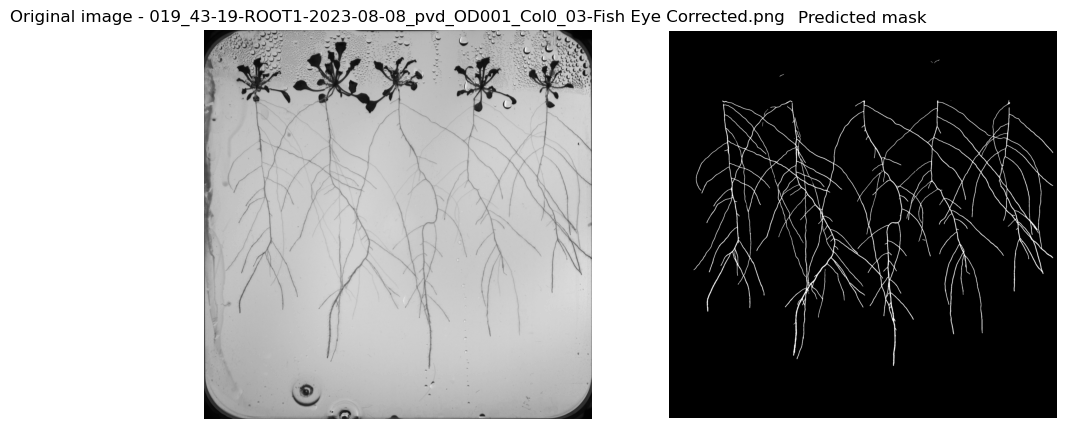

4/4 [==============================] - 1s 189ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


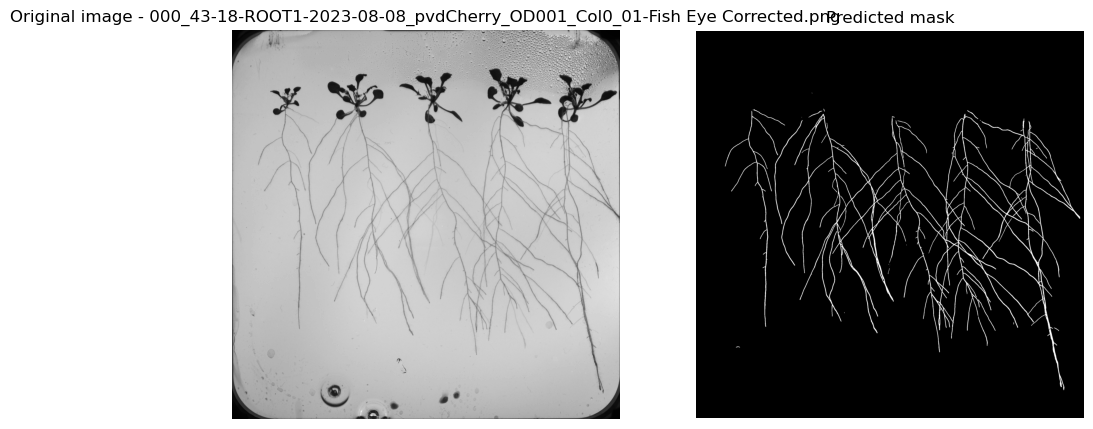

4/4 [==============================] - 0s 82ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


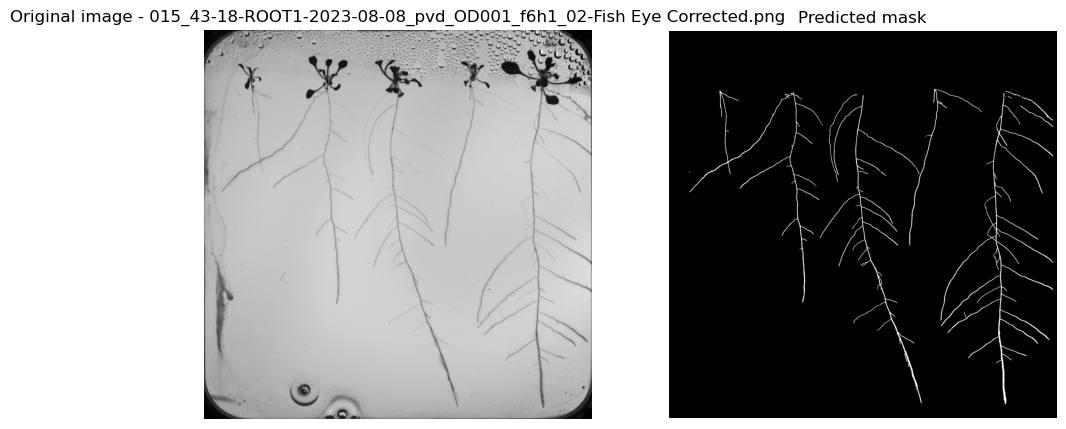

4/4 [==============================] - 0s 81ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


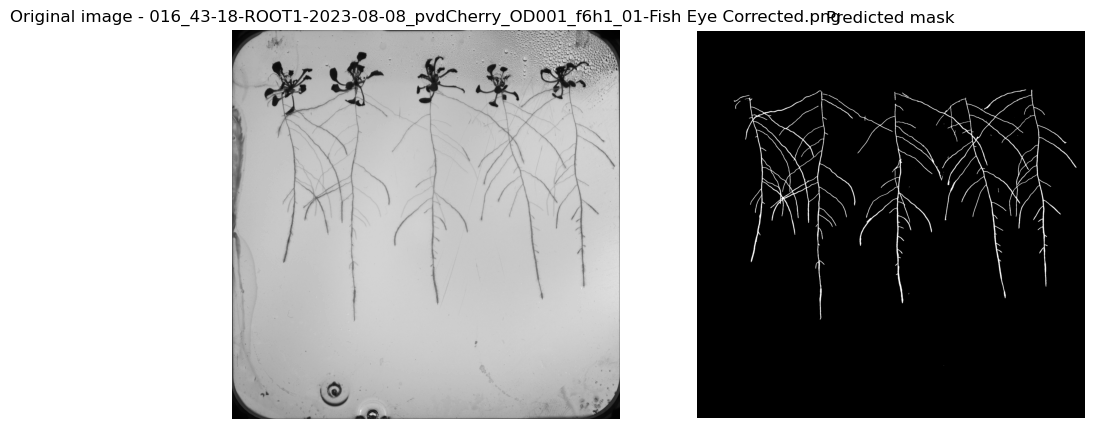

4/4 [==============================] - 0s 116ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


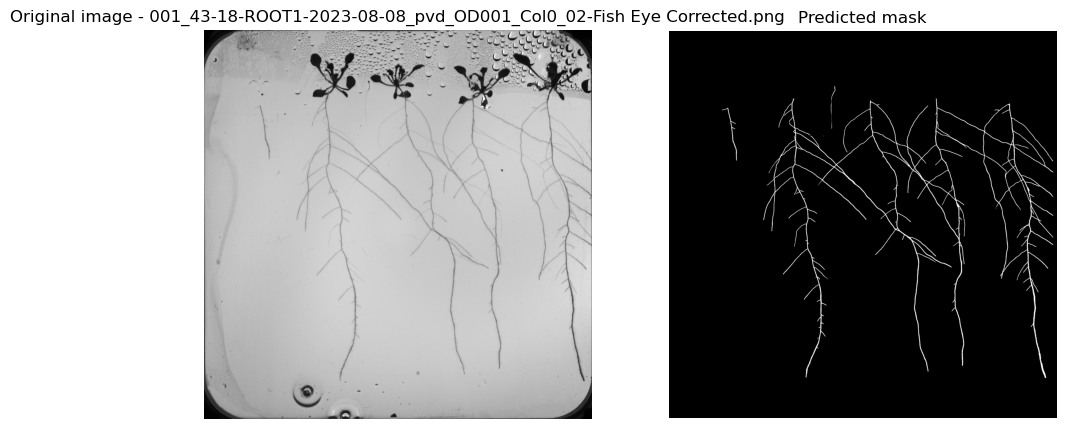

4/4 [==============================] - 0s 81ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


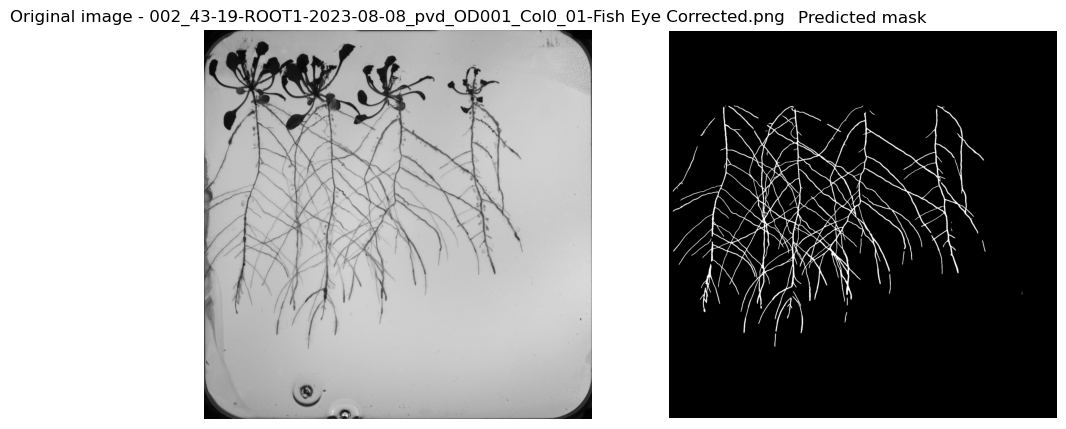

4/4 [==============================] - 0s 80ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


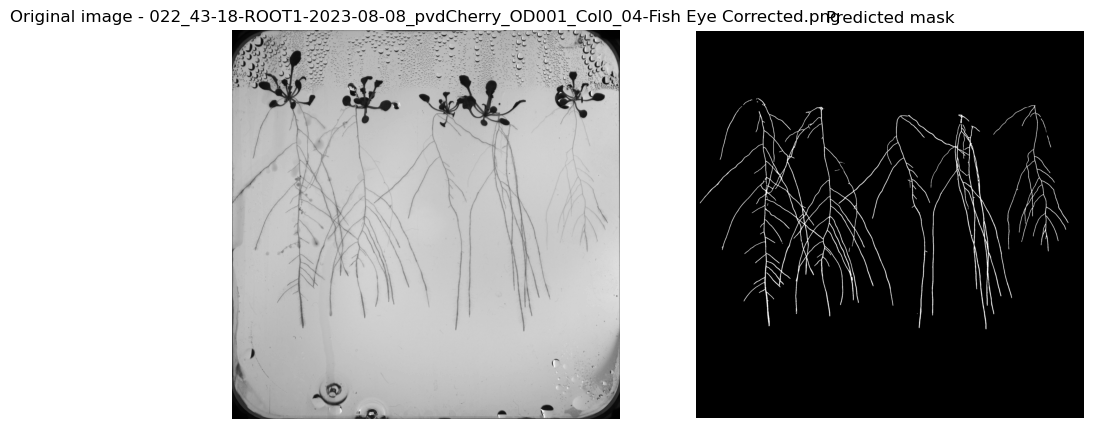

4/4 [==============================] - 0s 83ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


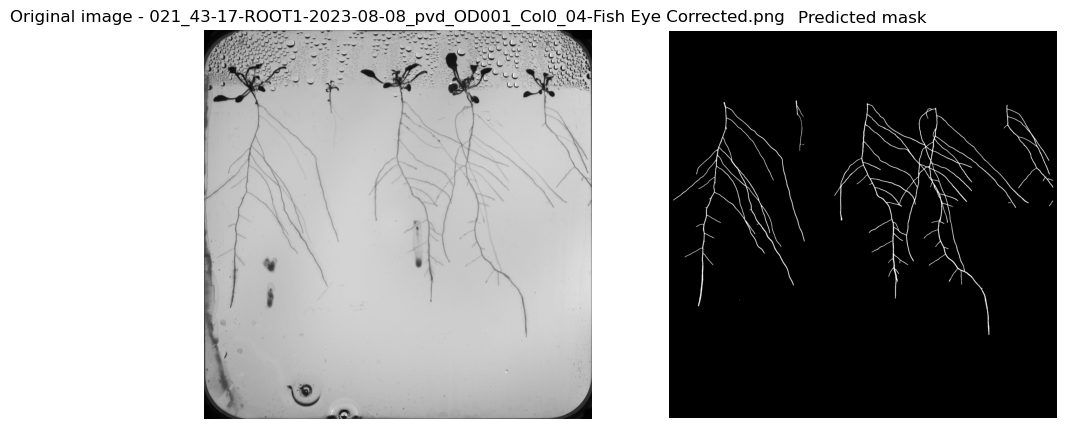

4/4 [==============================] - 0s 83ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


4/4 [==============================] - 0s 82ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


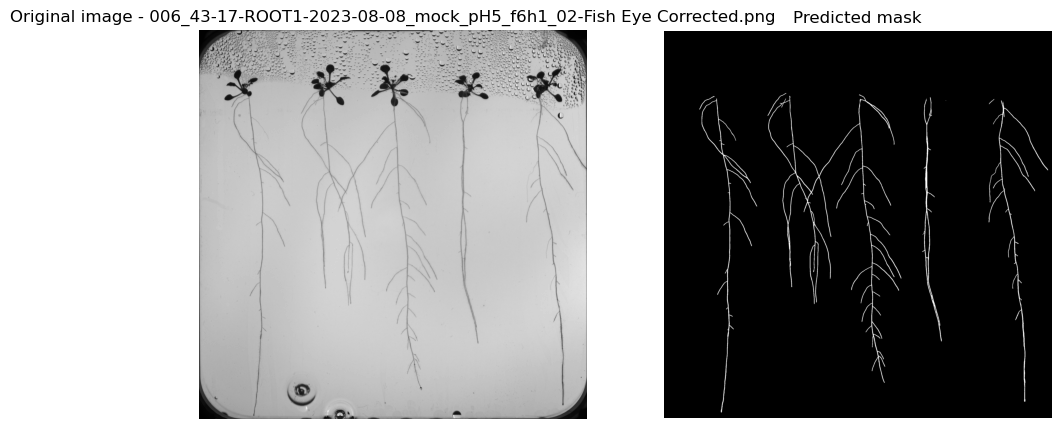

4/4 [==============================] - 0s 82ms/step
Mask shape: (2816, 2816)
Mask data type: uint8
Max Mask pixel values: 1
Min Mask pixel values: 0


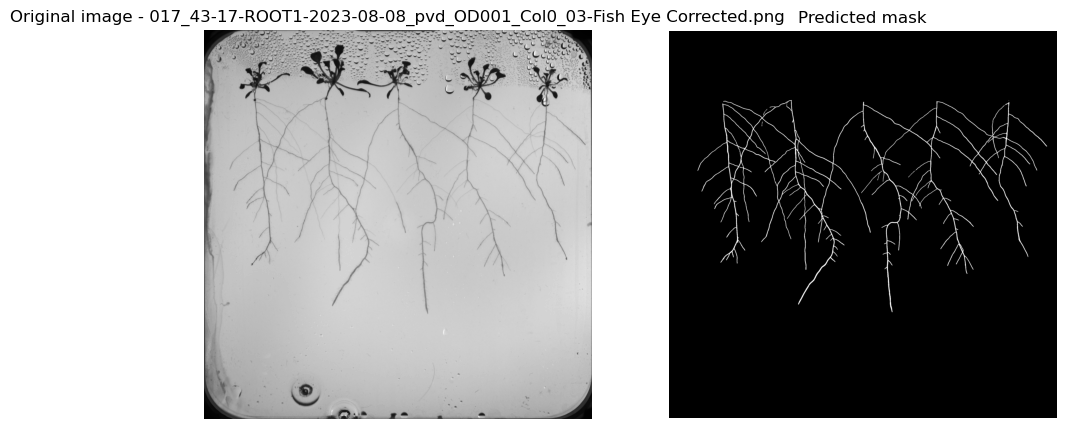

In [12]:
apply_model_predictions("images_hades_cropped", "images_hades_cropped_predictions", model)

### Finding bounding boxes for the plant's root mask and cropping them

In [173]:
# Define the folder name
folder_name = "each_root_mask"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder if it doesn't exist
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'each_root_mask' already exists.


#### Note the ROI extraction function performs well on the kaggle dataset and simple images of the test set but in certain more complex images from the test set (where there isn't a plant root in the first position for example) it can identify the correct plant root prediction but in the wrong place. 

#### I didn't include those for now and I already have a plan that will allow me to overcome those problems on those images. For now, I present you my current best work:

In [195]:
def roi_extraction(input_folder, output_folder):
    # Iterate over each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            file_path = os.path.join(input_folder, filename)

            # Read and process the image
            predicted_mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Ensure the y-coordinate 320 is within the image height
            if predicted_mask.shape[0] > 320:
                predicted_mask[:320, :] = 0
                predicted_mask[-510:, :] = 0

            predicted_mask_colour = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR) * 255

            retval, labels, stats, centroids = cv2.connectedComponentsWithStats(predicted_mask)

            # Find bounding boxes and areas
            bounding_boxes = []
            areas = []
            for i in range(1, len(stats)):
                x, y, w, h, _ = stats[i]
                bounding_boxes.append((x - 100, y - 160, w + 70, h + 520))
                areas.append(w * h)

            # Get top 5 bounding boxes
            top_5_indices = [areas.index(area) for area in sorted(areas, reverse=True)[:5]]
            top_5_boxes = [bounding_boxes[index] for index in top_5_indices]
            top_5_boxes_sorted_by_x = sorted(top_5_boxes, key=lambda box: box[0])

            # Initialize all ROIs as valid
            valid_rois = [True] * len(top_5_boxes_sorted_by_x)

            # Check if the 3rd ROI (from left to right) is not within x coordinates 1100 and 1900
            if len(top_5_boxes_sorted_by_x) >= 3:
                third_roi_x = top_5_boxes_sorted_by_x[2][0]
                if third_roi_x < 1100 or third_roi_x > 1600:
                    valid_rois[2] = False
                forth_roi_x = top_5_boxes_sorted_by_x[3][0]
                if forth_roi_x < 1600 or forth_roi_x > 2400:
                    valid_rois[3] = False

            # Check if there are any valid ROIs
            if not any(valid_rois):
                print(f"No valid ROIs found in {filename}.")
                continue  # Skip to the next file

            # Save the valid ROIs and plot them
            fig, axs = plt.subplots(1, sum(valid_rois) + 1, figsize=(20, 5))
            axs[0].imshow(predicted_mask, cmap='gray')
            axs[0].set_title(f'Original Mask - {filename}')

            ax_index = 1
            for i, (box, is_valid) in enumerate(zip(top_5_boxes_sorted_by_x, valid_rois)):
                if not is_valid:
                    continue

                x, y, w, h = box
                x1, y1 = max(0, x - 40), max(0, y - 60)
                x2, y2 = min(x + w + 80, predicted_mask.shape[1]), min(y + h + 60, predicted_mask.shape[0])
                roi = predicted_mask[y1:y2, x1:x2] * 255
                output_filename = os.path.join(output_folder, f"{filename.split('.')[0]}_plant_{i+1}.tif")
                cv2.imwrite(output_filename, roi)
                axs[ax_index].imshow(roi, cmap='gray')
                axs[ax_index].set_title(f'ROI {i+1}')
                ax_index += 1

            for ax in axs:
                ax.axis('off')

            plt.show()


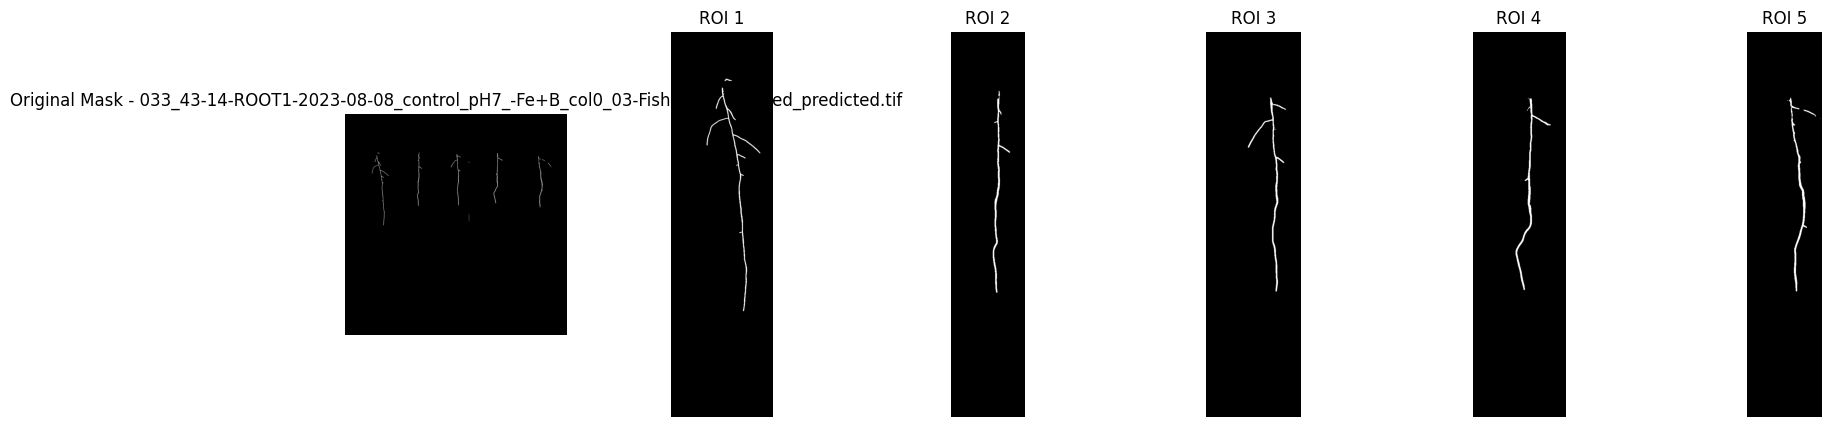

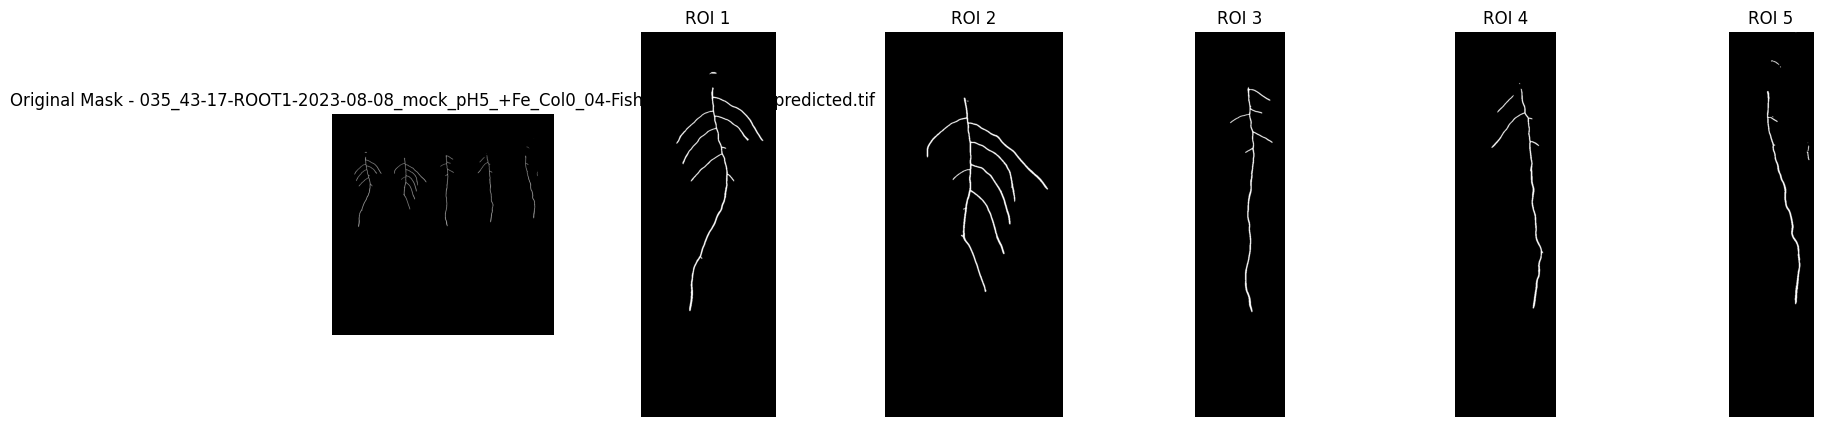

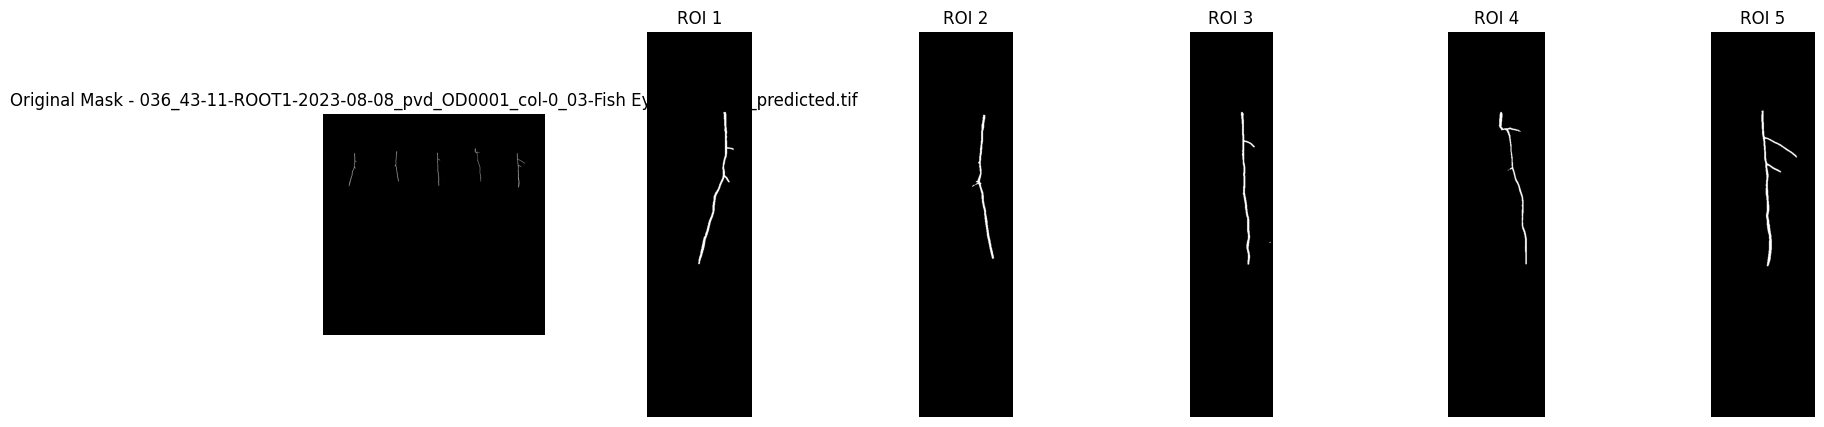

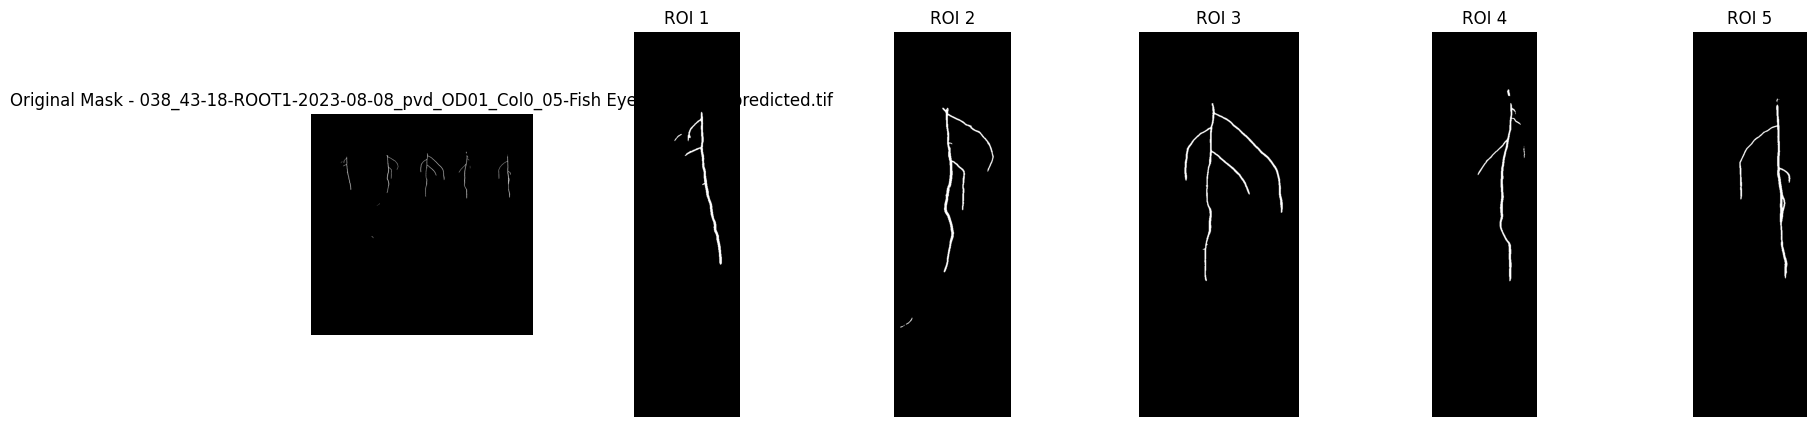

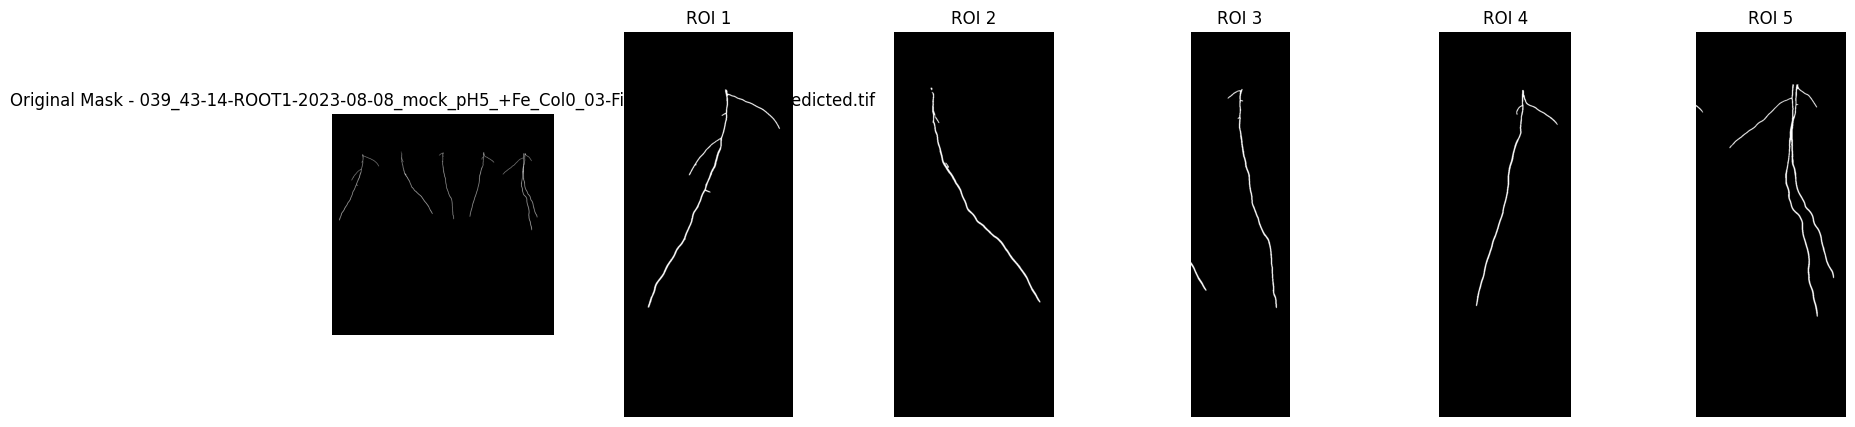

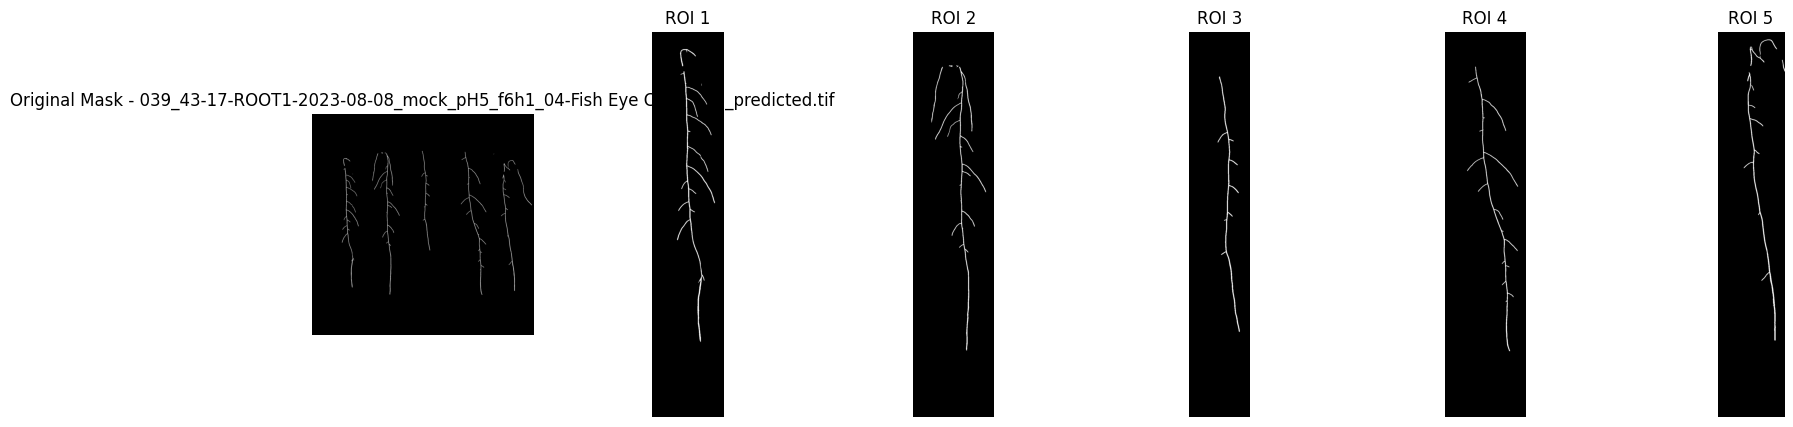

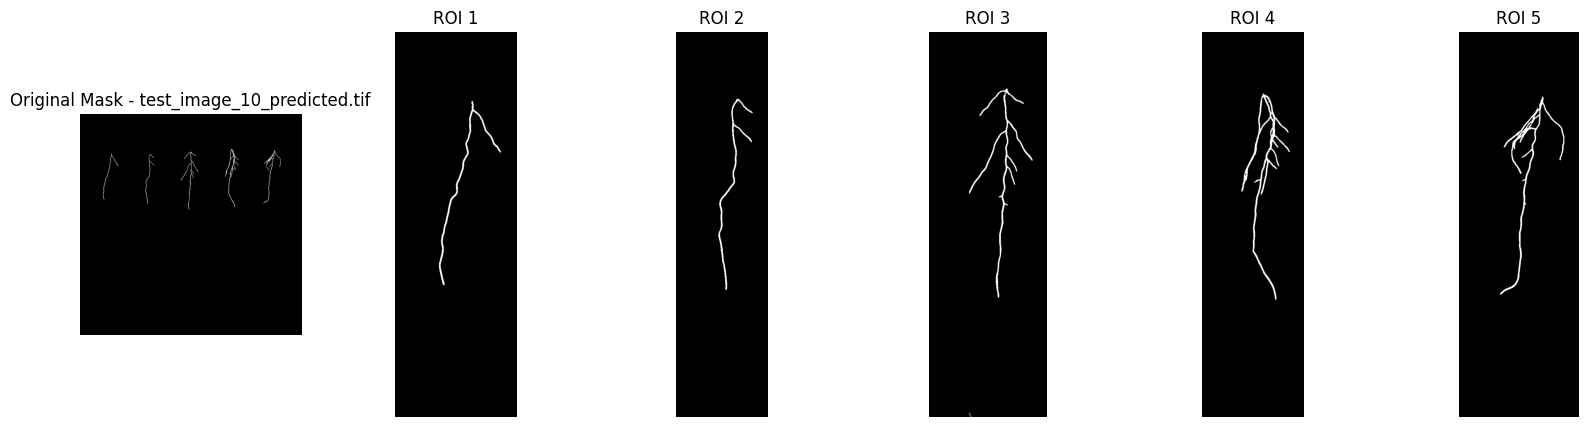

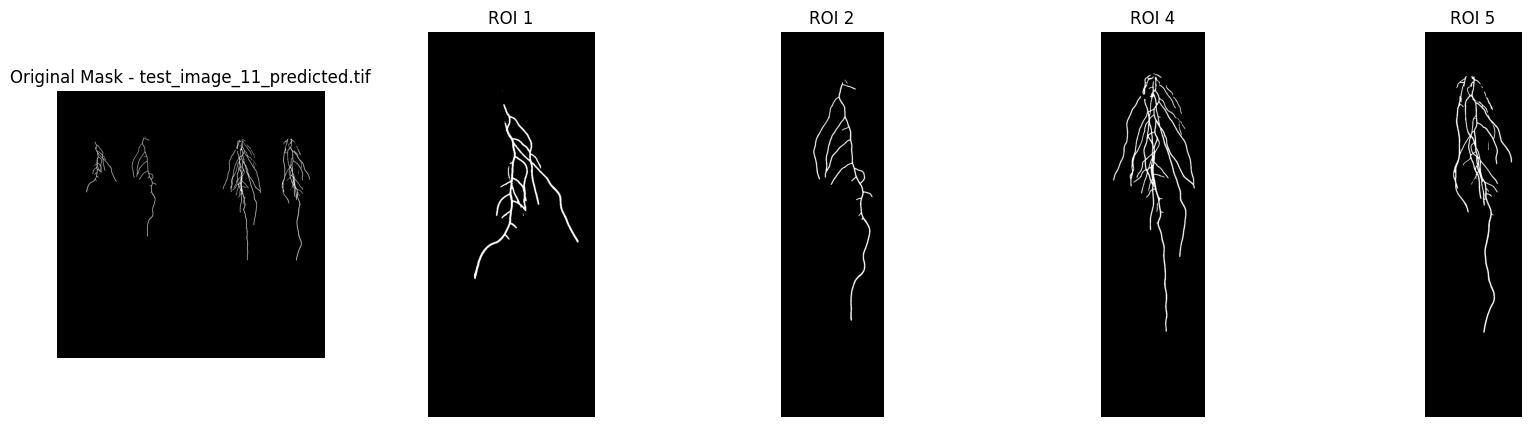

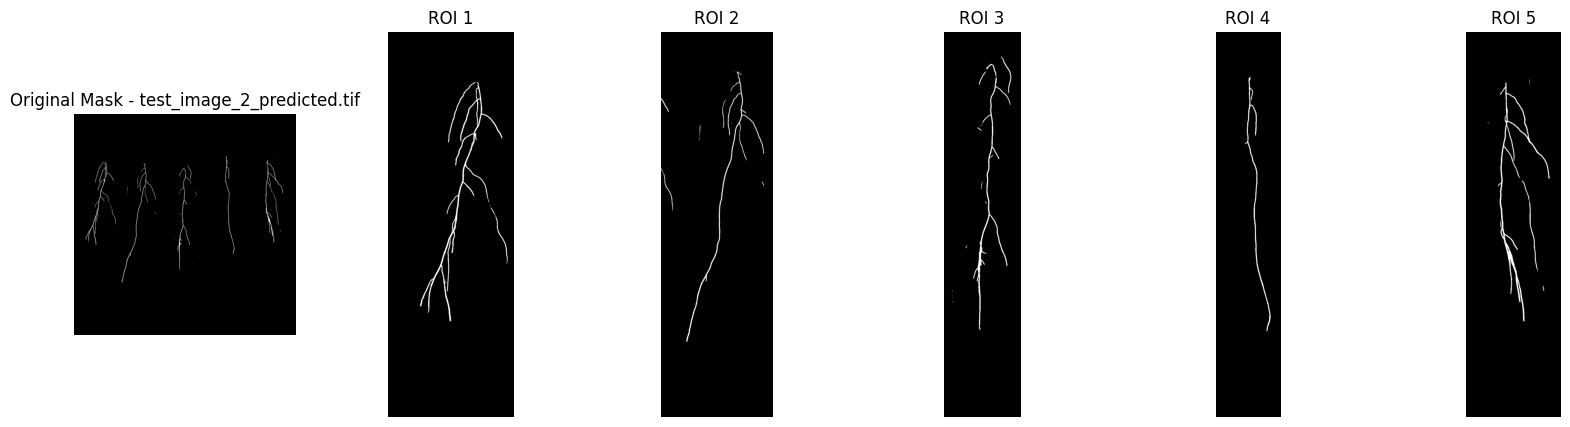

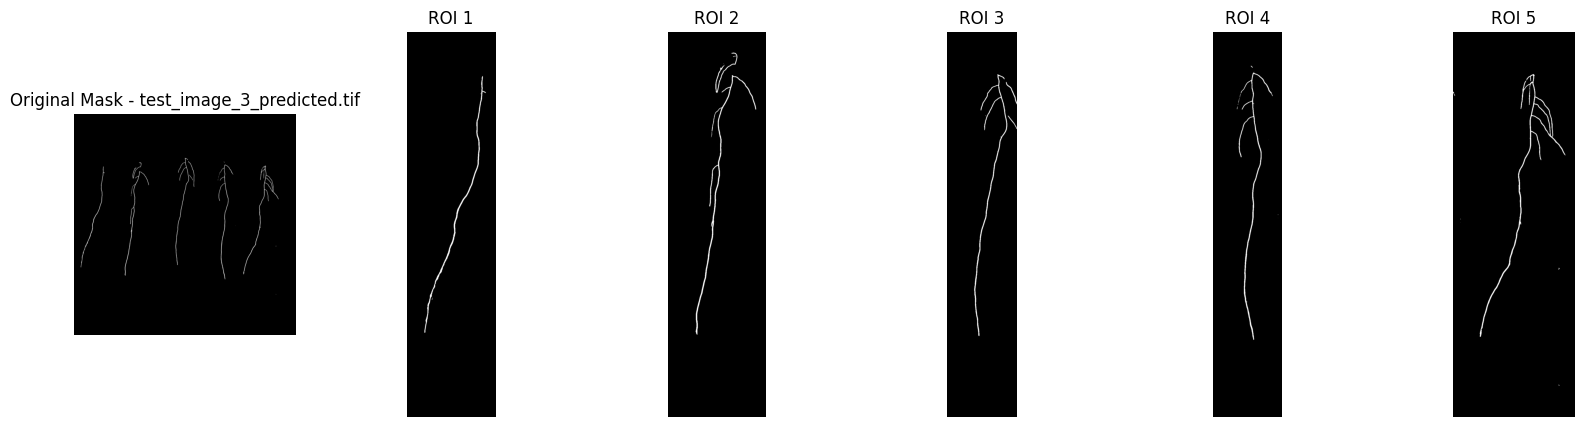

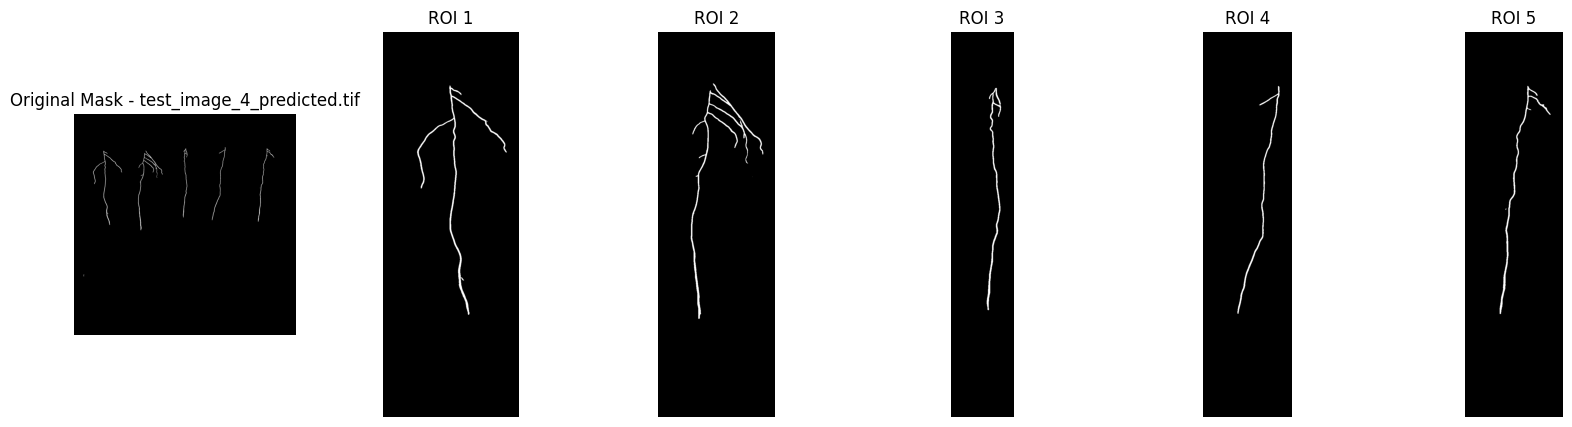

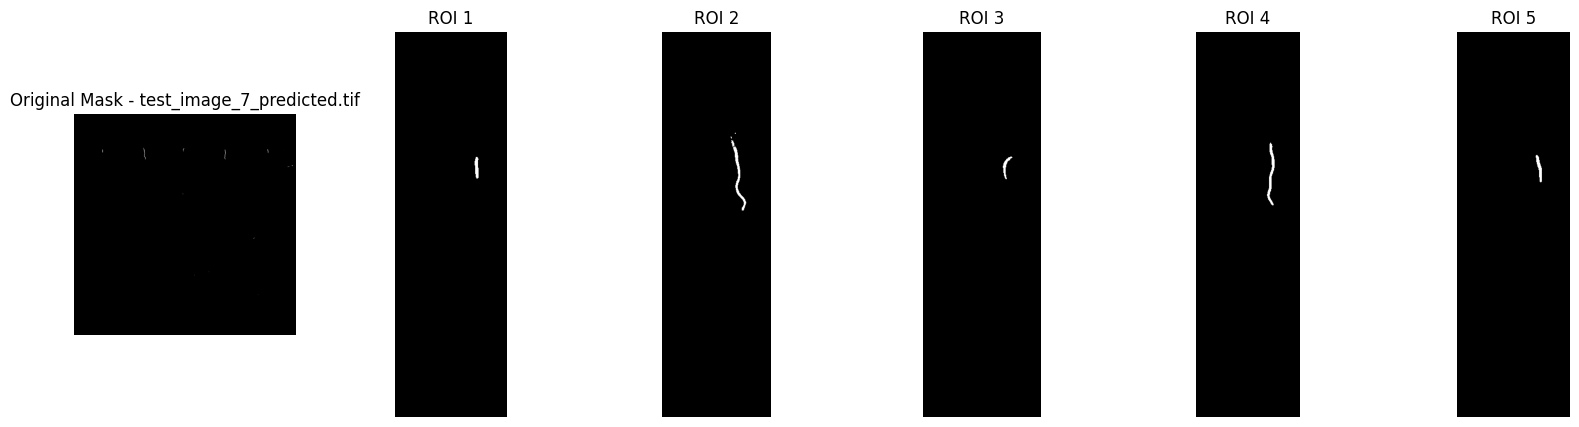

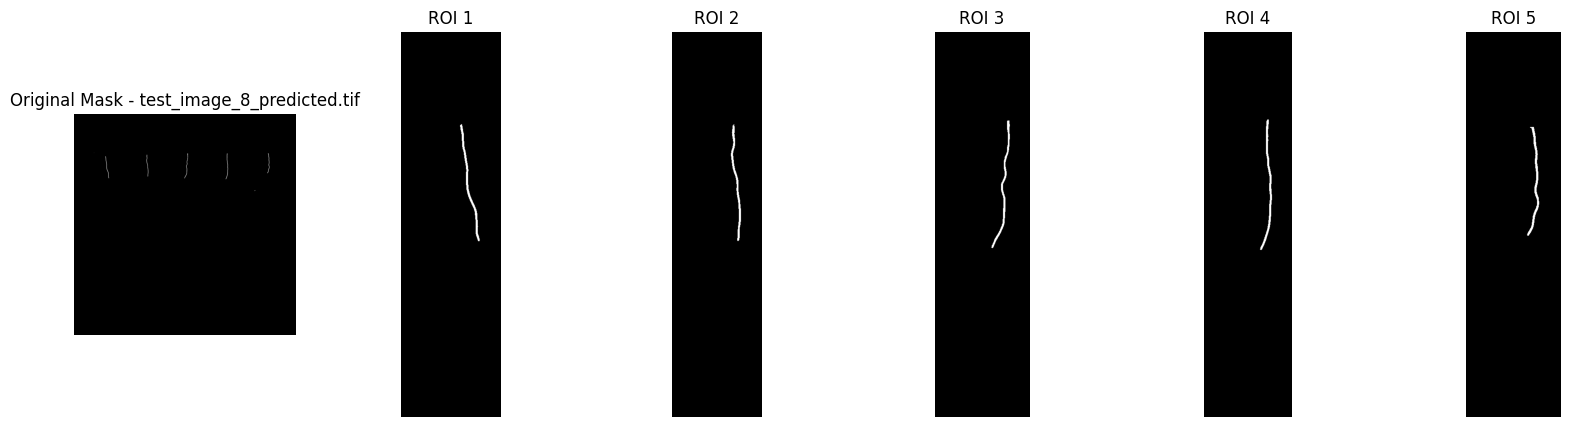

In [196]:
# Example usage
input_folder = 'images_hades_cropped_predictions'
output_folder = 'each_root_mask'
roi_extraction(input_folder, output_folder)

## Measurement

#### creating a dataframe to store the values

creating folder to store the dataframes

In [198]:
# Define the folder name
folder_name = "dataframe_measurements"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder if it doesn't exist
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'dataframe_measurements' already exists.


In [202]:
# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=["Plant ID", "Length (px)"])

# Specify the folder containing images
image_folder = 'images_hades_cropped'

# Initialize an index for DataFrame rows
index = 0

# Loop through each file in the image folder
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.tif')):
        processed_filename = filename.replace('.png', '').replace('.tif', '')
        for i in range(1, 6):
            plant_id = f'{processed_filename}_plant_{i}'
            df.loc[index] = [plant_id, 0]
            index += 1

# Create a folder for the dataframe if it does not exist
output_folder = 'dataframe_measurements'
os.makedirs(output_folder, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(f'{output_folder}/sample.csv', index=False)


#### Measurement code and functions

In [193]:
# Function to process a single skeleton
def process_single_skeleton(skeleton_branch_data, image):
    # Create a graph from the provided skeleton branch data
    G = nx.from_pandas_edgelist(skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    
    # Loop through unique skeleton IDs
    for skeleton_id in skeleton_branch_data['skeleton-id'].unique():
        root_tips = skeleton_branch_data[skeleton_branch_data['skeleton-id'] == skeleton_id]

        # Check if there are any root tips for this skeleton
        if not root_tips.empty:
            # Find the minimum and maximum rows based on source and destination coordinates
            min_row = root_tips.loc[root_tips['coord-src-0'].idxmin()]
            max_row = root_tips.loc[root_tips['coord-dst-0'].idxmax()]

            # Extract coordinates for the junction and root tip
            junction = (int(min_row['coord-src-0']), int(min_row['coord-src-1']))
            root_tip = (int(max_row['coord-dst-0']), int(max_row['coord-dst-1']))

            # Draw circles on the image to mark the junction and root tip
            cv2.circle(image, junction[::-1], 15, (0, 255, 0), 4)  # Green circle for junction
            cv2.circle(image, root_tip[::-1], 15, (0, 0, 255), 4)  # Red circle for root tip

            # Add edges from the skeleton data to the graph
            for _, row in skeleton_branch_data.iterrows():
                src_node = row['node-id-src']
                dst_node = row['node-id-dst']
                distance = row['branch-distance']
                G.add_edge(src_node, dst_node, branch_distance=distance)

            junction_node_id = min_row['node-id-src']
            root_tip_node_id = max_row['node-id-dst']

            # Calculate the length of the path from junction to root tip in the graph
            length = nx.dijkstra_path_length(G, junction_node_id, root_tip_node_id, weight='branch_distance')
            
            # Return the calculated length
            return length

In [194]:
# Function to process multiple skeletons and return the maximum length
def process_multiple_skeletons(skeleton_branch_data, image):
    # Create a graph from the provided skeleton branch data
    G = nx.from_pandas_edgelist(skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

    # Initialize a list to store lengths of processed skeletons
    lengths = []
    
    # Loop through unique skeleton IDs (sorted)
    for skeleton_id in sorted(skeleton_branch_data['skeleton-id'].unique()):
        root_tips = skeleton_branch_data[skeleton_branch_data['skeleton-id'] == skeleton_id]

        # Check if there are any root tips for this skeleton
        if not root_tips.empty:
            # Find the minimum and maximum rows based on source and destination coordinates
            min_row = root_tips.loc[root_tips['coord-src-0'].idxmin()]
            max_row = root_tips.loc[root_tips['coord-dst-0'].idxmax()]

            # Extract coordinates for the junction and root tip
            junction = (int(min_row['coord-src-0']), int(min_row['coord-src-1']))
            root_tip = (int(max_row['coord-dst-0']), int(max_row['coord-dst-1']))

            # Draw circles on the image to mark the junction and root tip
            cv2.circle(image, junction[::-1], 15, (0, 255, 0), 4)  # Green circle for junction
            cv2.circle(image, root_tip[::-1], 15, (0, 0, 255), 4)  # Red circle for root tip

            # Add edges from the skeleton data to the graph
            for _, row in skeleton_branch_data.iterrows():
                src_node = row['node-id-src']
                dst_node = row['node-id-dst']
                distance = row['branch-distance']
                G.add_edge(src_node, dst_node, branch_distance=distance)

            junction_node_id = min_row['node-id-src']
            root_tip_node_id = max_row['node-id-dst']

            # Calculate the length of the path from junction to root tip in the graph
            length = nx.dijkstra_path_length(G, junction_node_id, root_tip_node_id, weight='branch_distance')
            
            # Append the length to the list
            lengths.append(length)

    # Return the maximum length among all processed skeletons, or 0 if no skeletons were processed
    return max(lengths) if lengths else 0

In [207]:
def process_images_in_folder(folder_path):
    """
    Processes images in a given folder, identifying features' lengths and updating a DataFrame.

    The function iterates over TIFF images in the specified folder, performs image processing to skeletonize the images,
    and calculates the length of the skeletonized features. It updates a DataFrame with these lengths and saves the
    DataFrame to a new CSV file. Additionally, it plots the original and skeletonized (or dilated skeletonized) images.

    Parameters:
    - folder_path (str): The path to the folder containing the images to be processed.

    Returns:
    - DataFrame: The updated DataFrame containing the lengths of features for each processed image.
    """

    # Initialize an empty list to store results (unused in the provided snippet)
    results = []

    # Read a CSV file into a DataFrame and initialize a new column for storing lengths
    df = pd.read_csv('dataframe_measurements/sample.csv')

    # Iterate over all files in the given folder path
    for filename in os.listdir(folder_path):
        # Process only TIFF files
        if filename.endswith(".tif"):
            # Remove specific substrings from the filename to match the DataFrame entries
            processed_filename = filename.replace('_predicted', '').replace('.tif', '')

            # Construct the full path to the image and load it
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            # Perform skeletonization on the image
            skeleton = skeletonize(image)
            # Summarize the skeleton data, likely extracting features such as branch lengths
            skeleton_branch_data = summarize(Skeleton(skeleton))
            # Initialize display_skeleton which will be used for plotting
            display_skeleton = skeleton  # Default to the original skeleton

            # Process the skeleton based on the number of unique skeleton IDs found
            if len(skeleton_branch_data['skeleton-id'].unique()) == 1:
                # Process a single skeleton
                length = process_single_skeleton(skeleton_branch_data, image)
            else:
                # Dilate the image and re-skeletonize for multiple skeletons
                kernel = np.ones((5, 5), dtype="uint8")
                im_blobs_dilation = cv2.dilate(image.astype(np.uint8), kernel, iterations=4)
                skeleton_dilated = skeletonize(im_blobs_dilation)
                skeleton_branch_data_dilated = summarize(Skeleton(skeleton_dilated))
                length = process_multiple_skeletons(skeleton_branch_data_dilated, image)
                display_skeleton = skeleton_dilated  # Use the dilated skeleton for display

            # Update the DataFrame with the calculated length for the matching filename
            if processed_filename in df['Plant ID'].values:
                df.loc[df['Plant ID'] == processed_filename, 'Length (px)'] = length

            # Plot the original image and its corresponding skeleton (or dilated skeleton)
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(display_skeleton, cmap='gray')
            plt.title('Skeleton' if skeleton is display_skeleton else 'Dilated Skeleton')

            plt.suptitle(f'Image: {filename} - Length: {length} pixels')
            plt.show()

    # Save the updated DataFrame to a new CSV file
    df.to_csv('dataframe_measurements/results.csv', index=False)

    # Return the updated DataFrame
    return df


C:\Users\franc\AppData\Local\Temp\ipykernel_29636\1269353282.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '954.1736649163068' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Plant ID'] == processed_filename, 'Length (px)'] = length


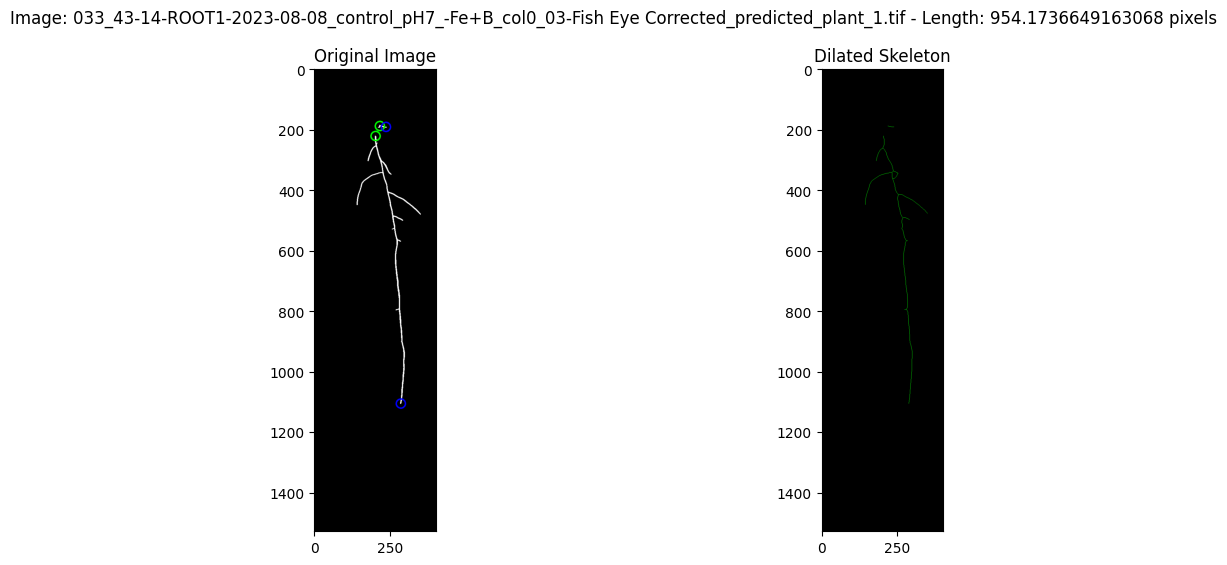

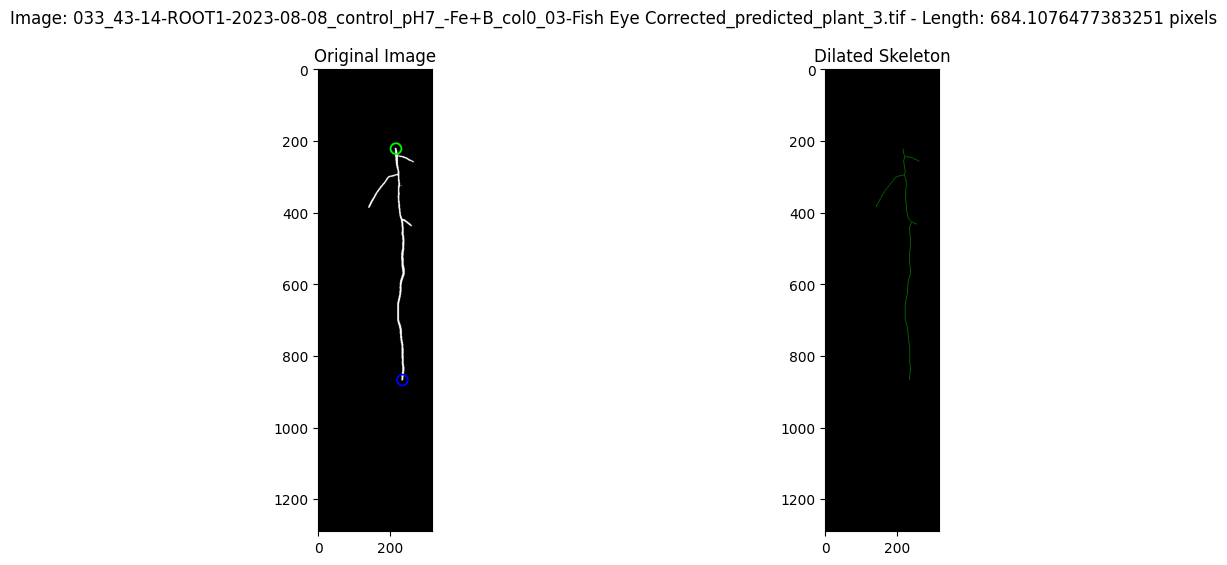

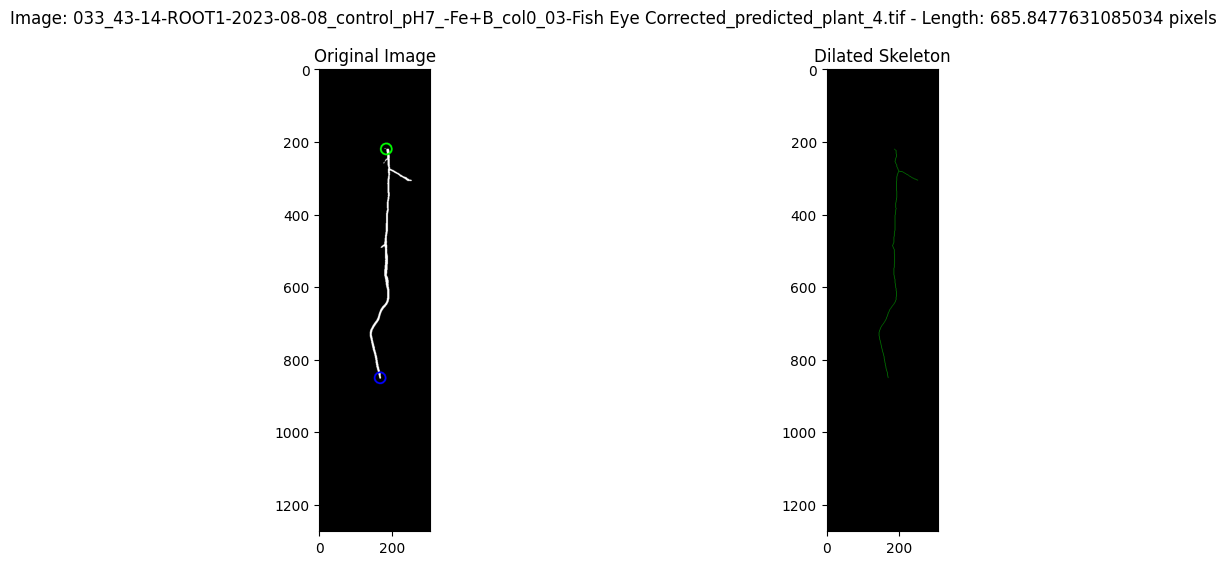

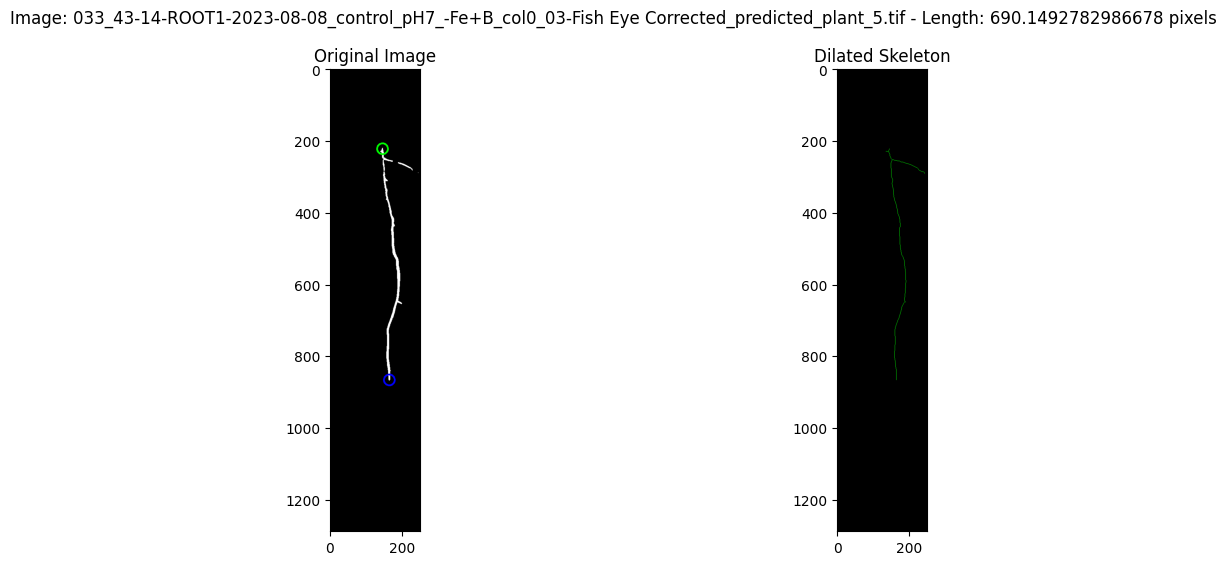

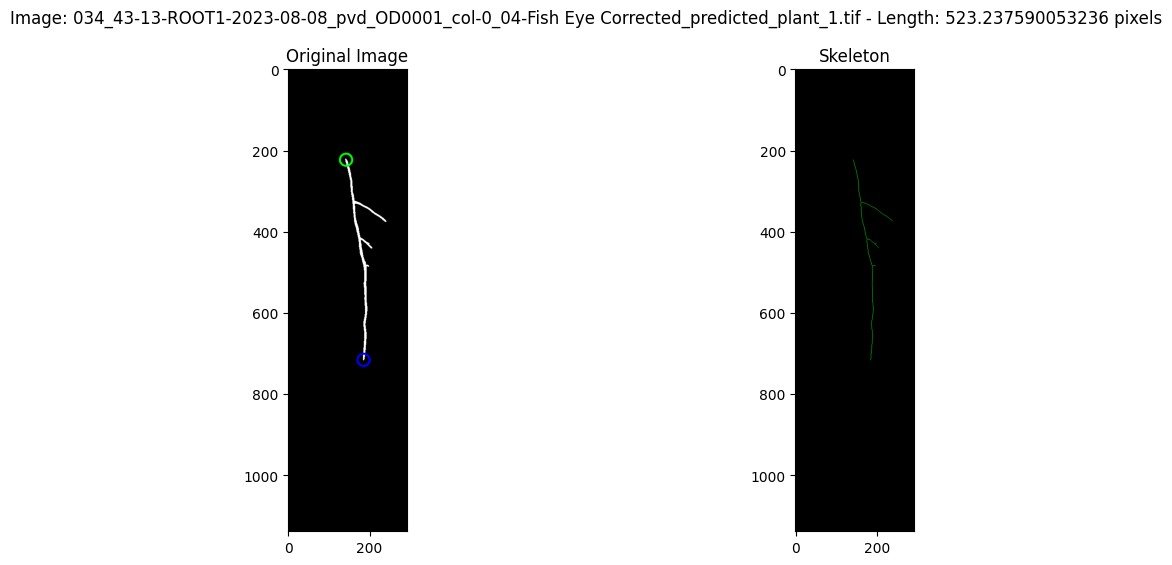

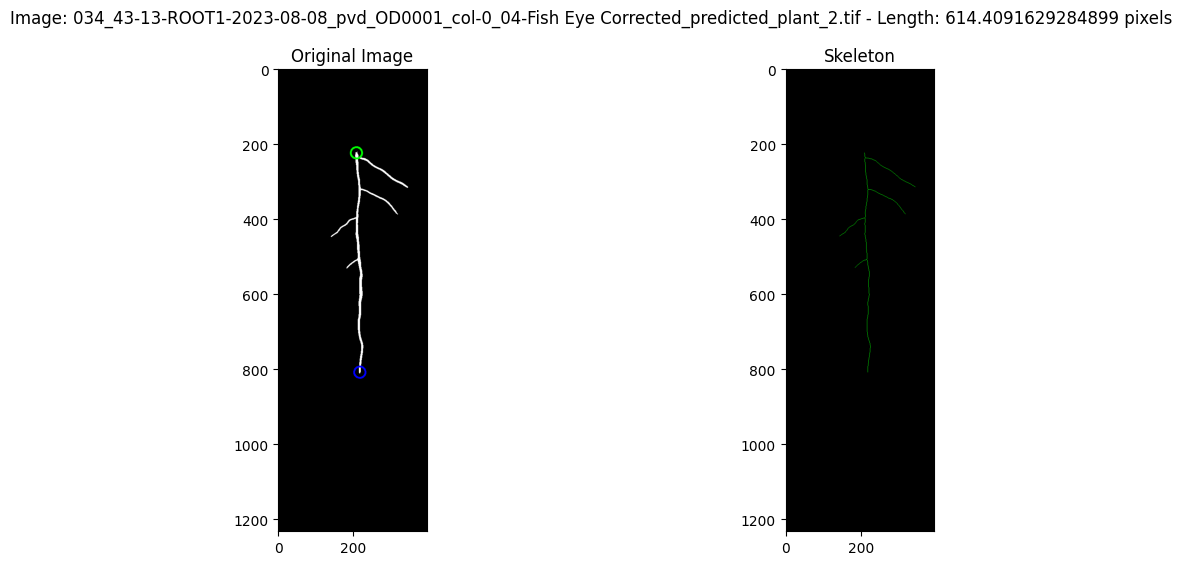

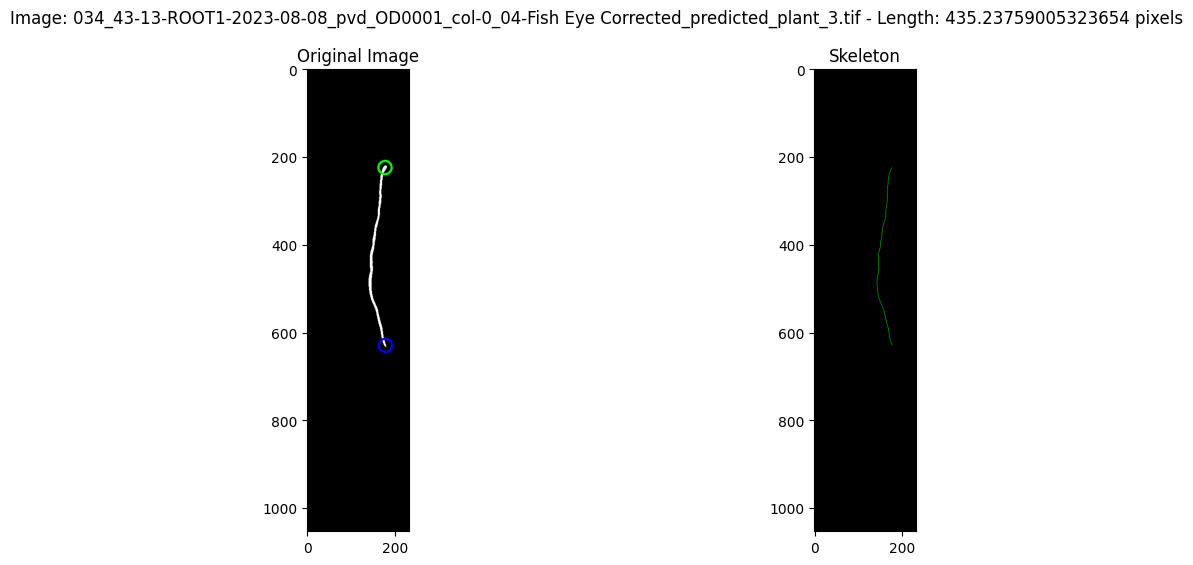

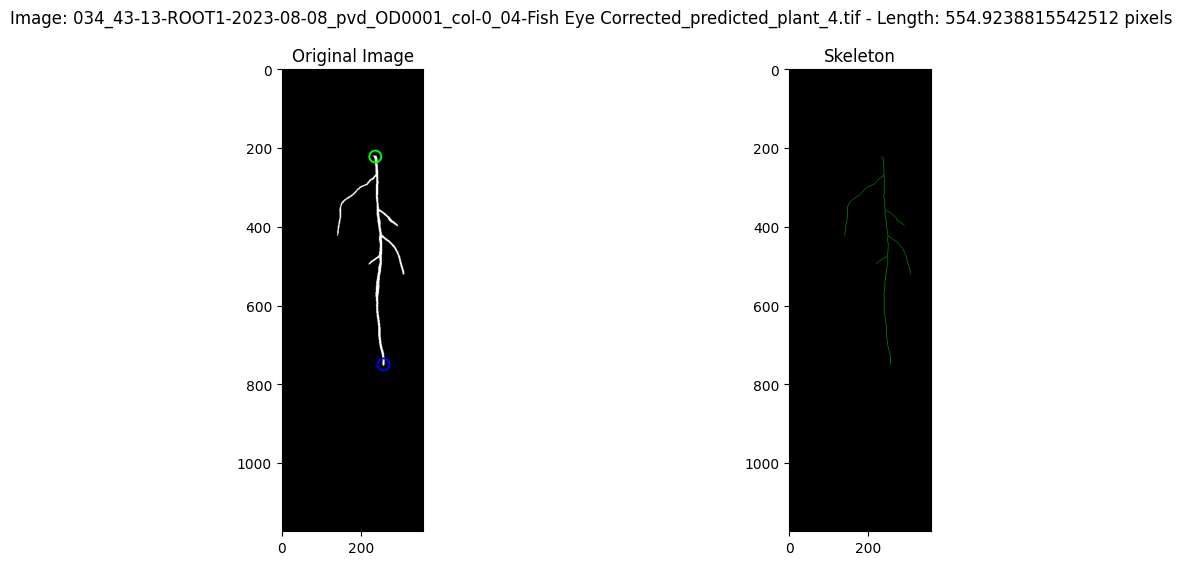

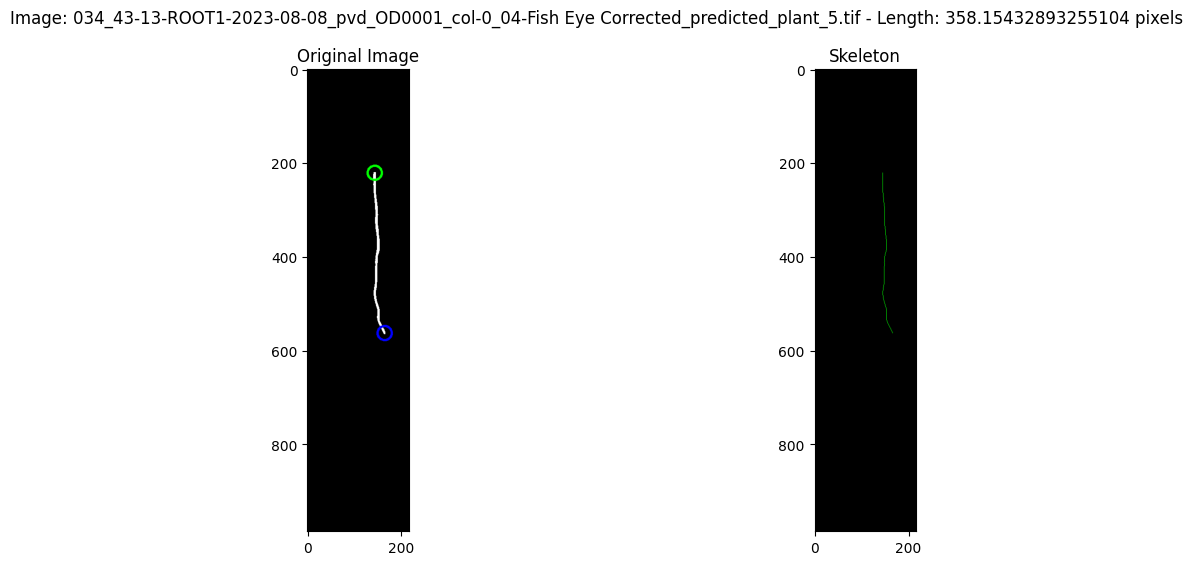

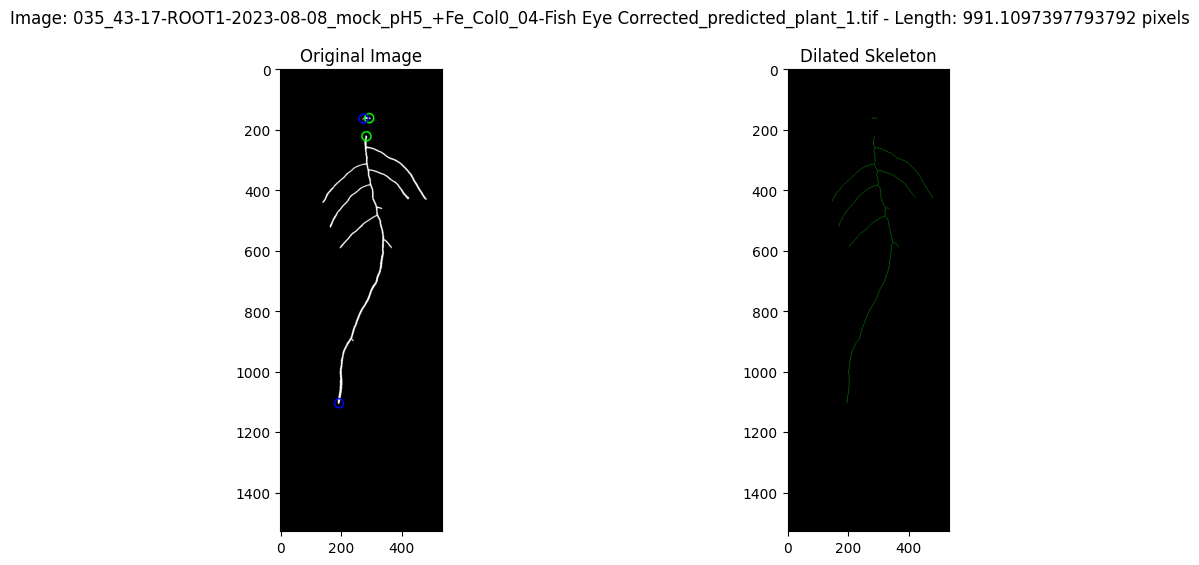

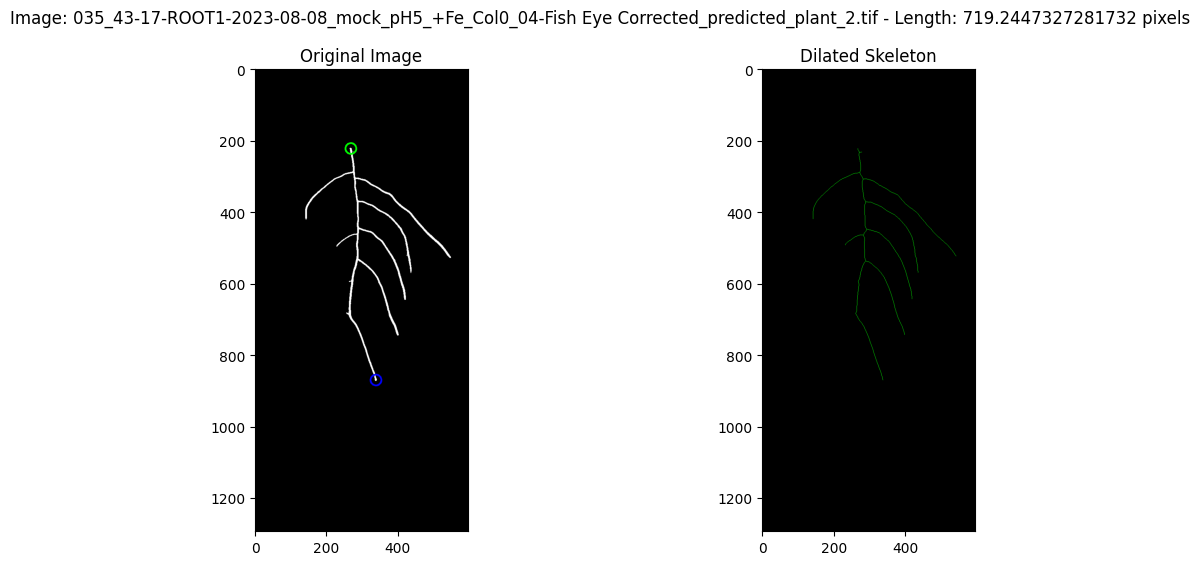

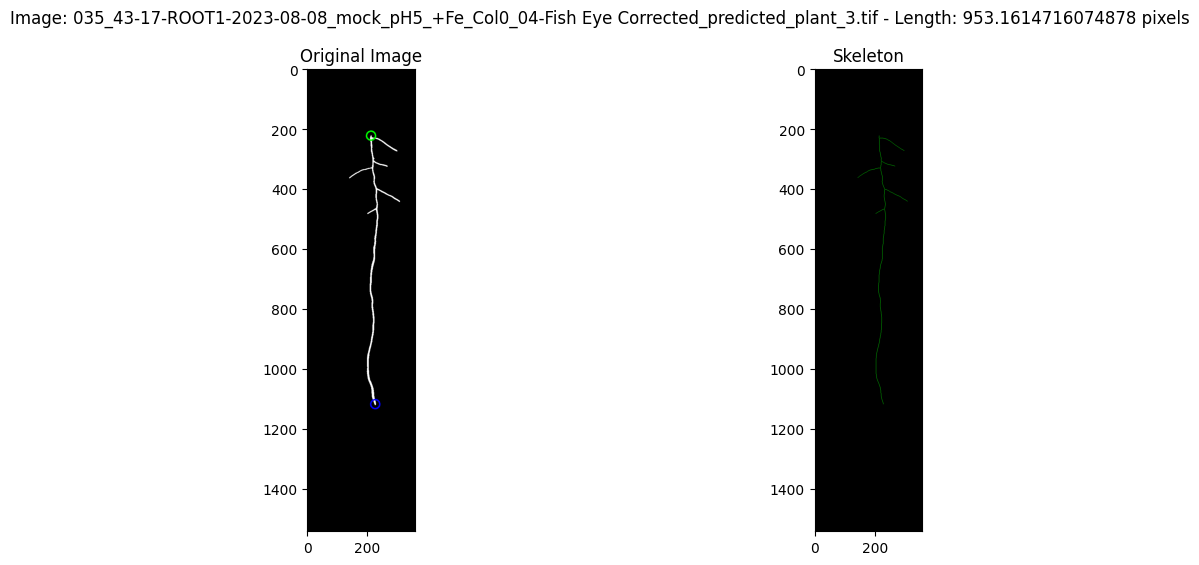

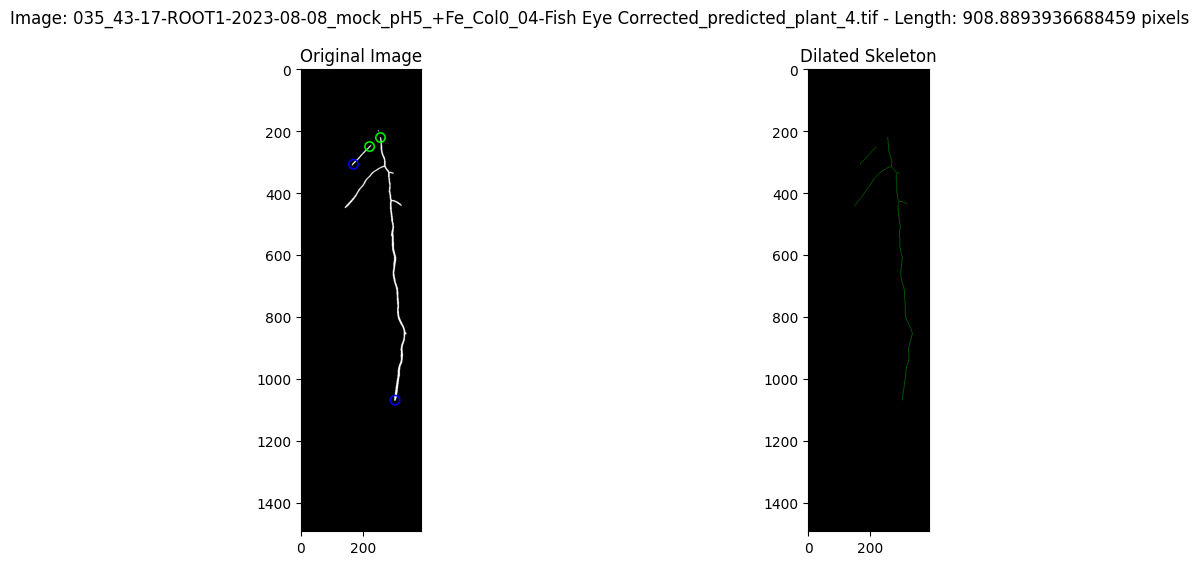

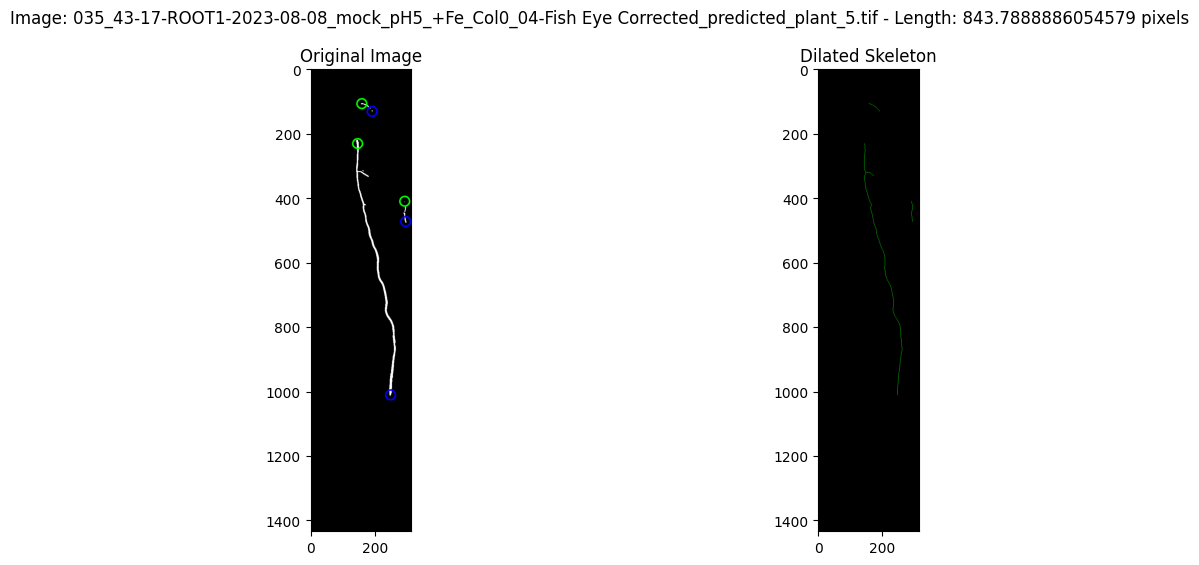

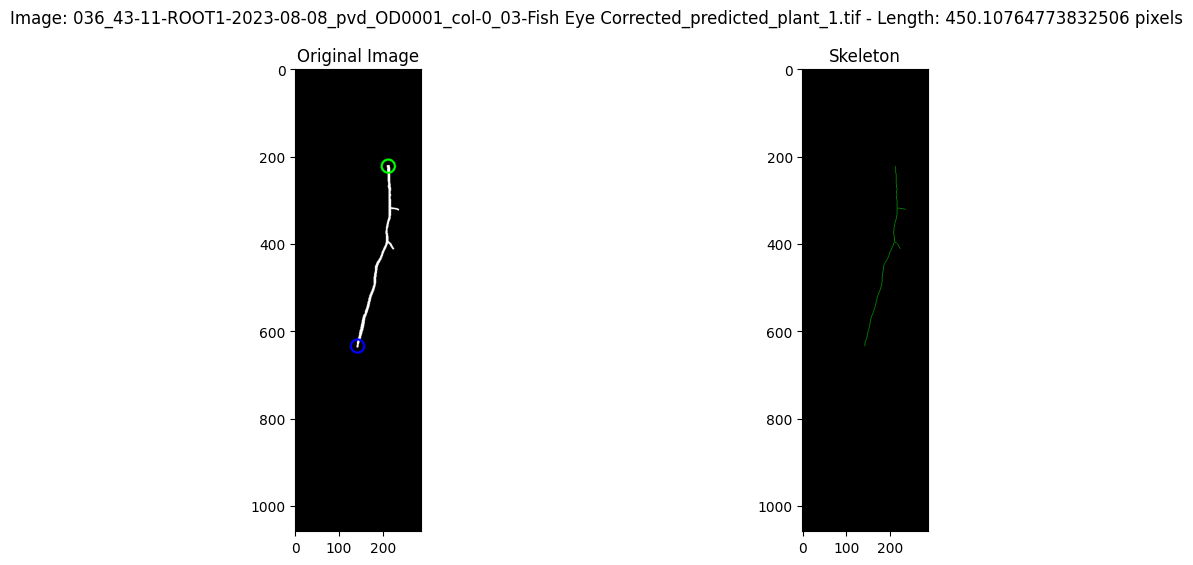

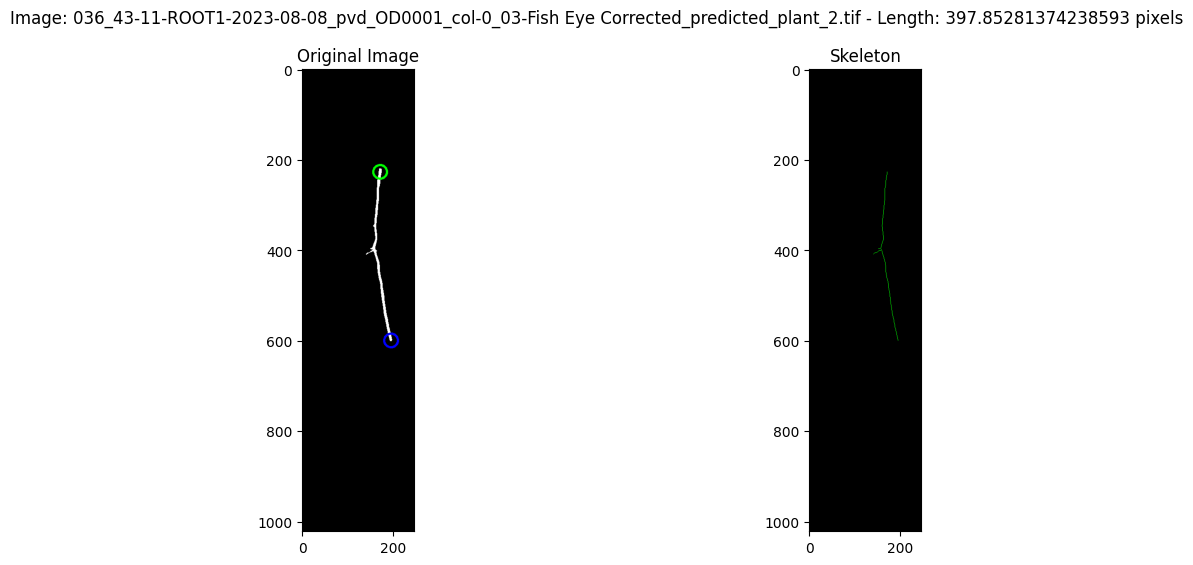

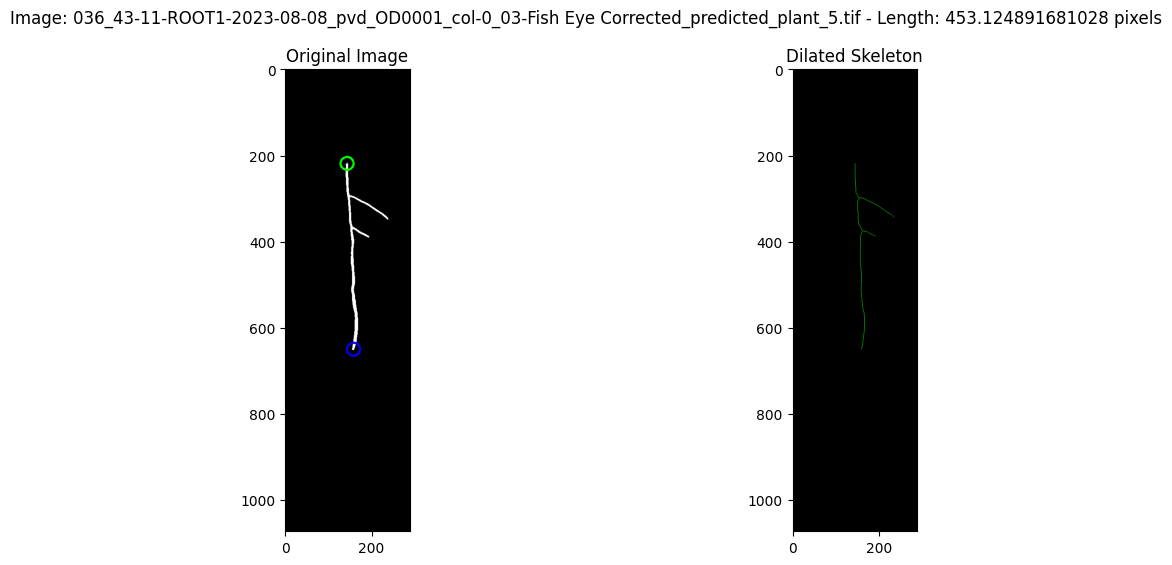

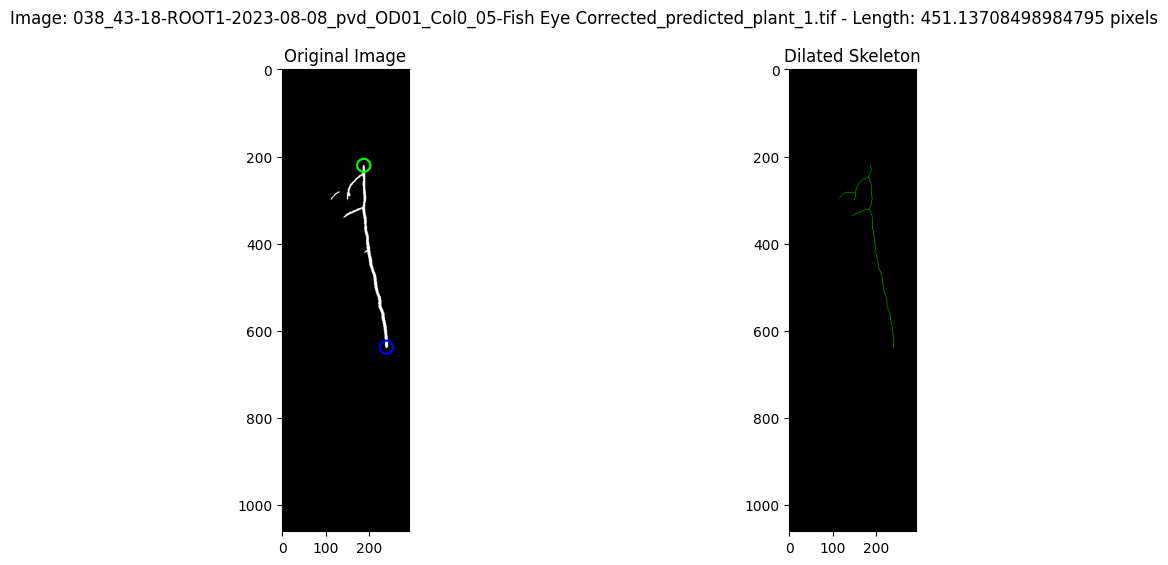

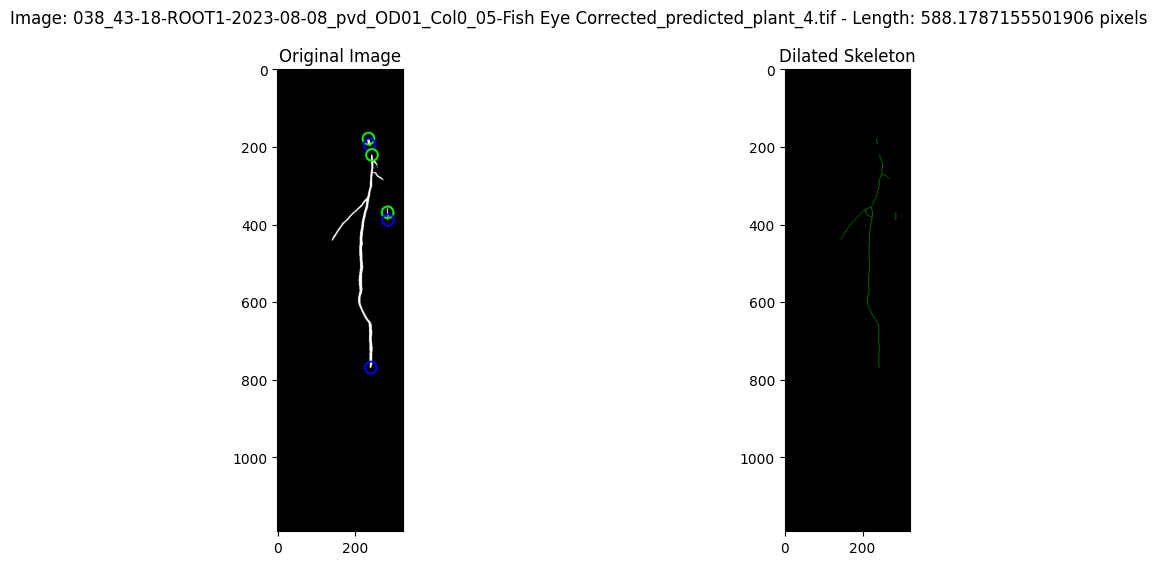

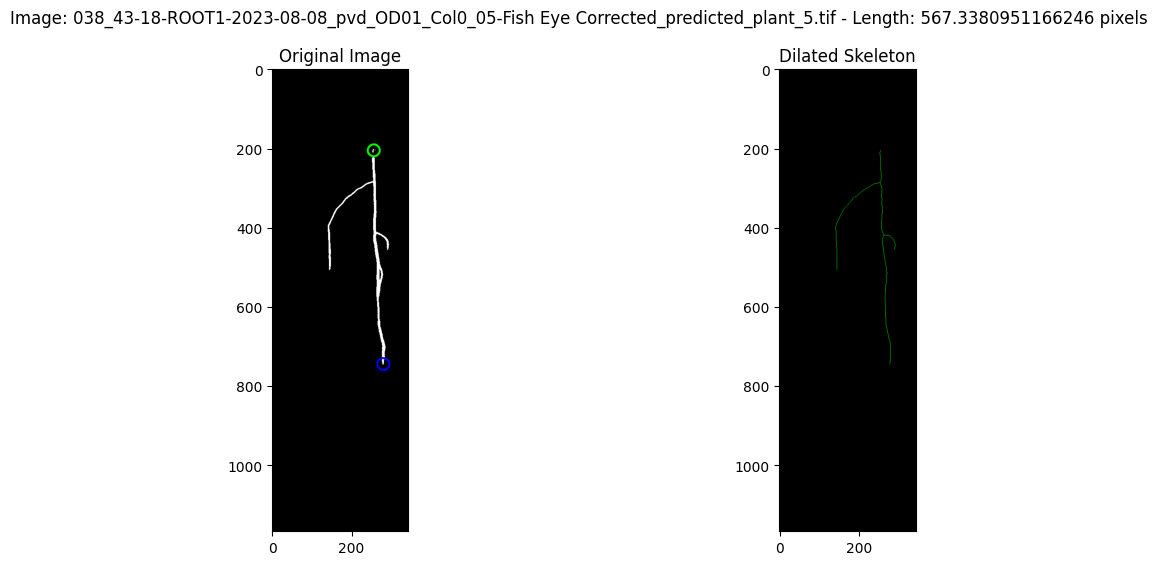

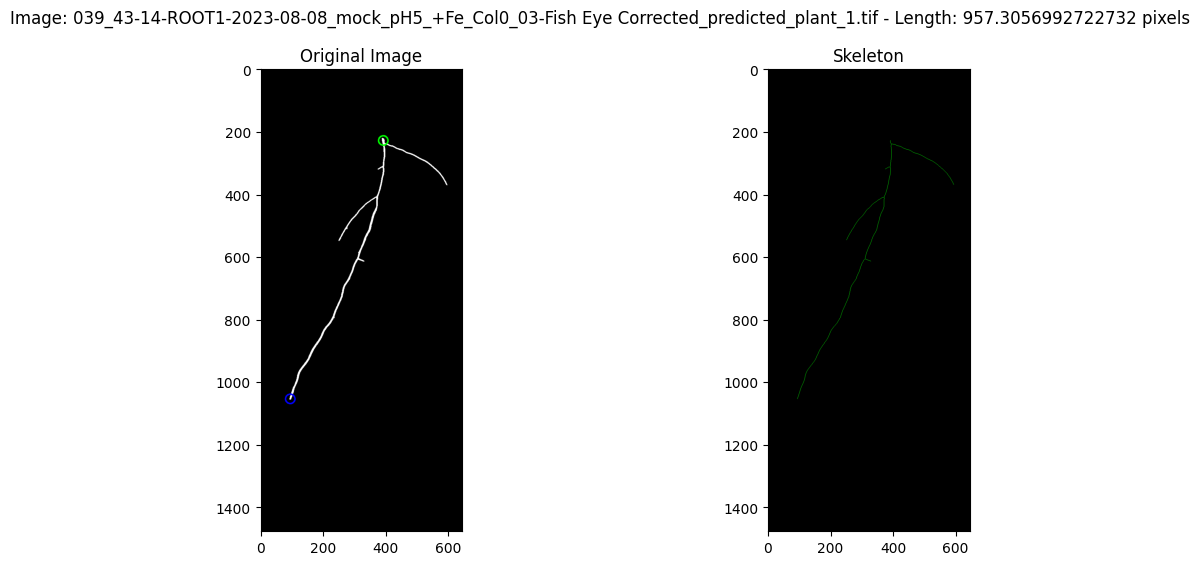

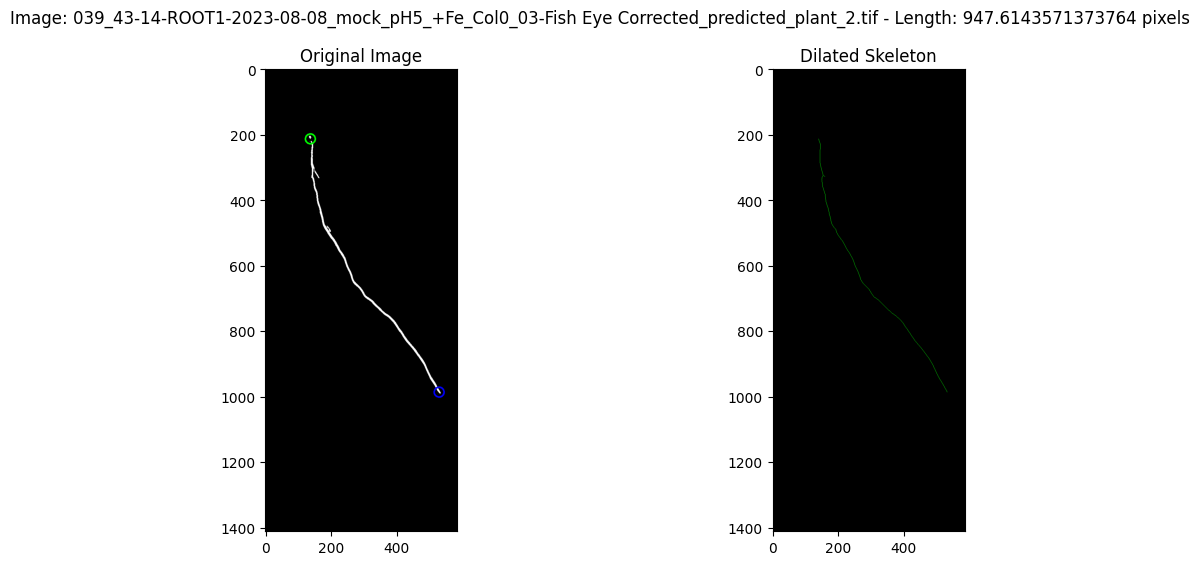

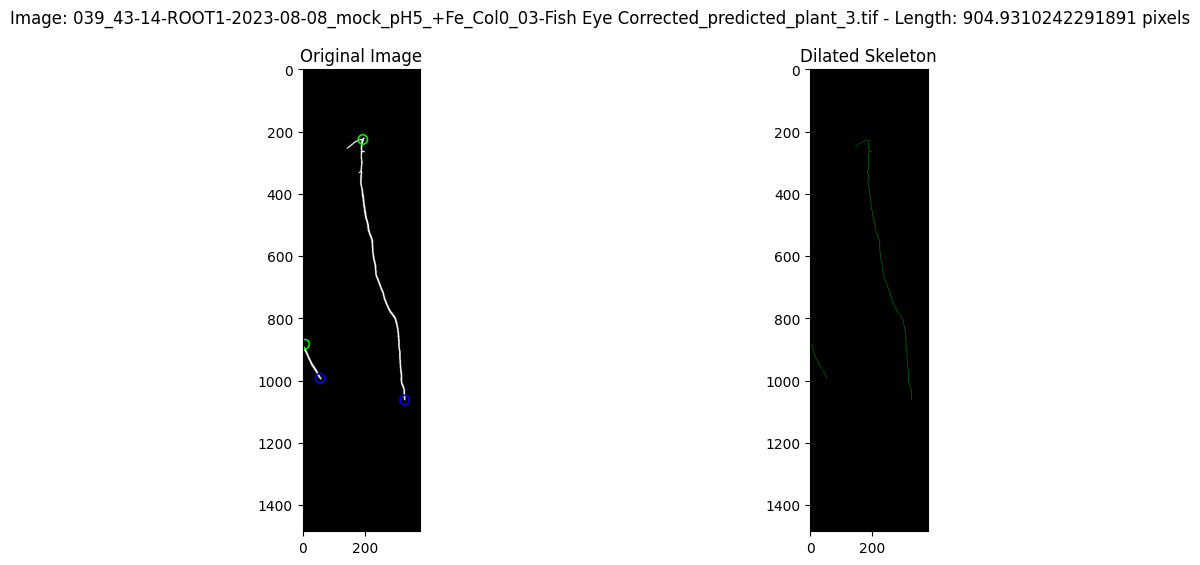

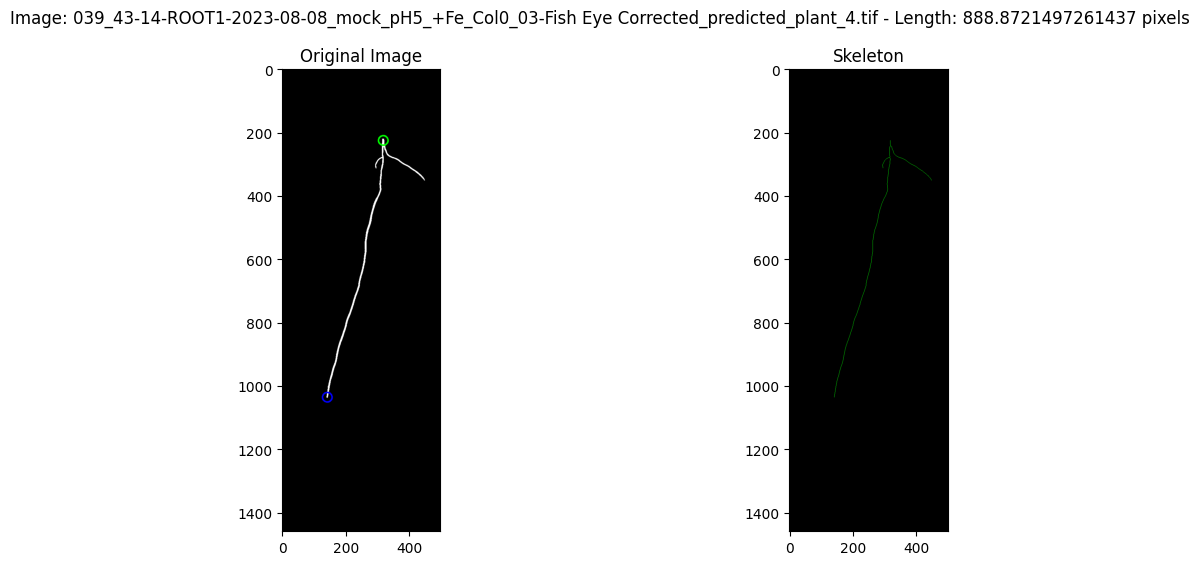

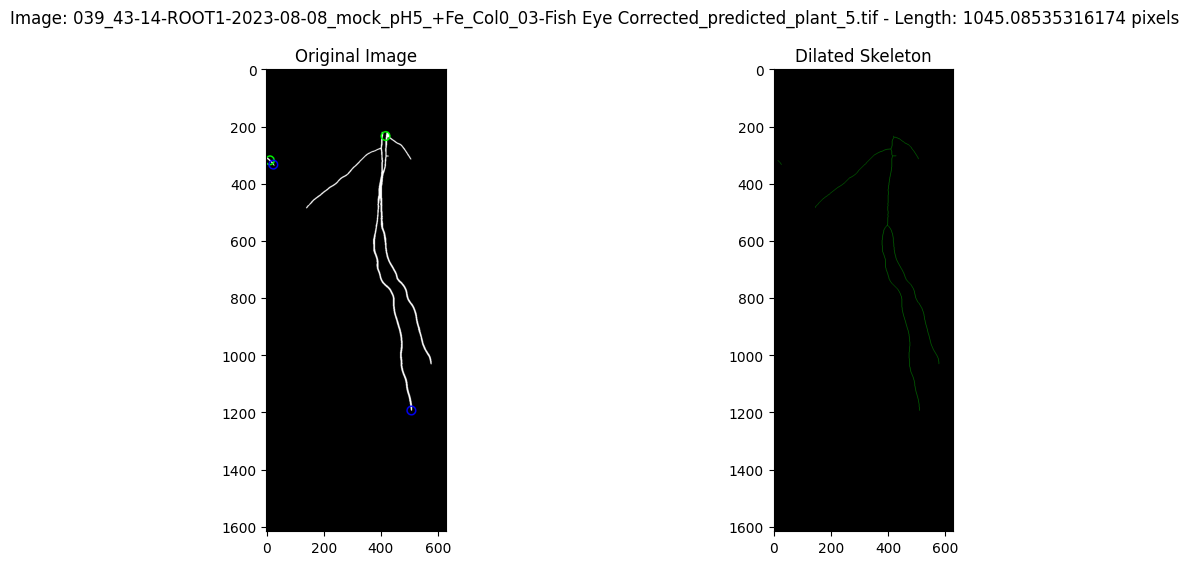

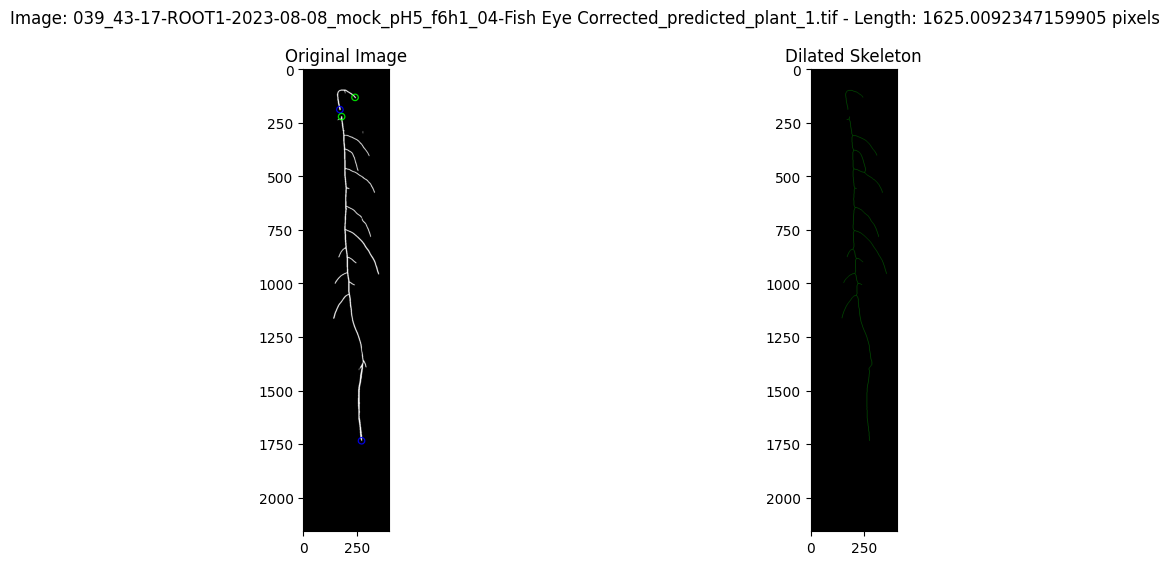

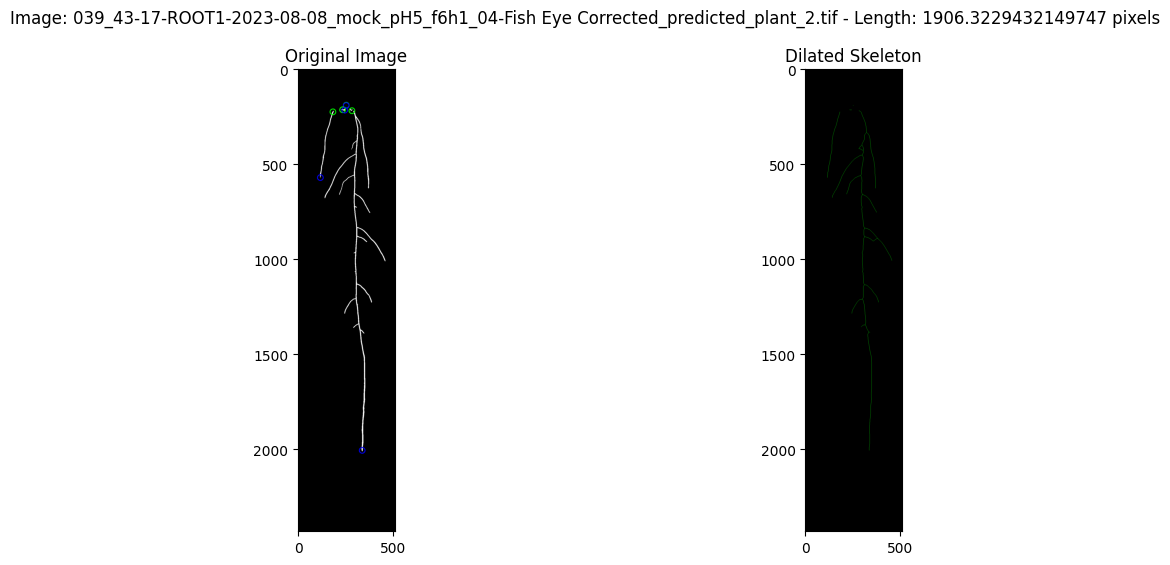

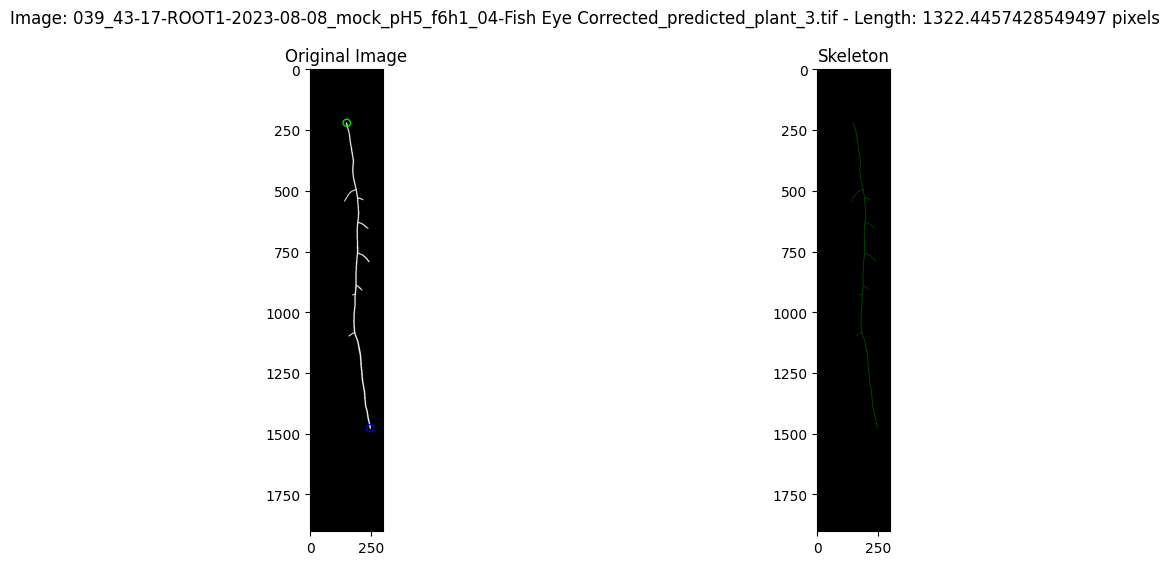

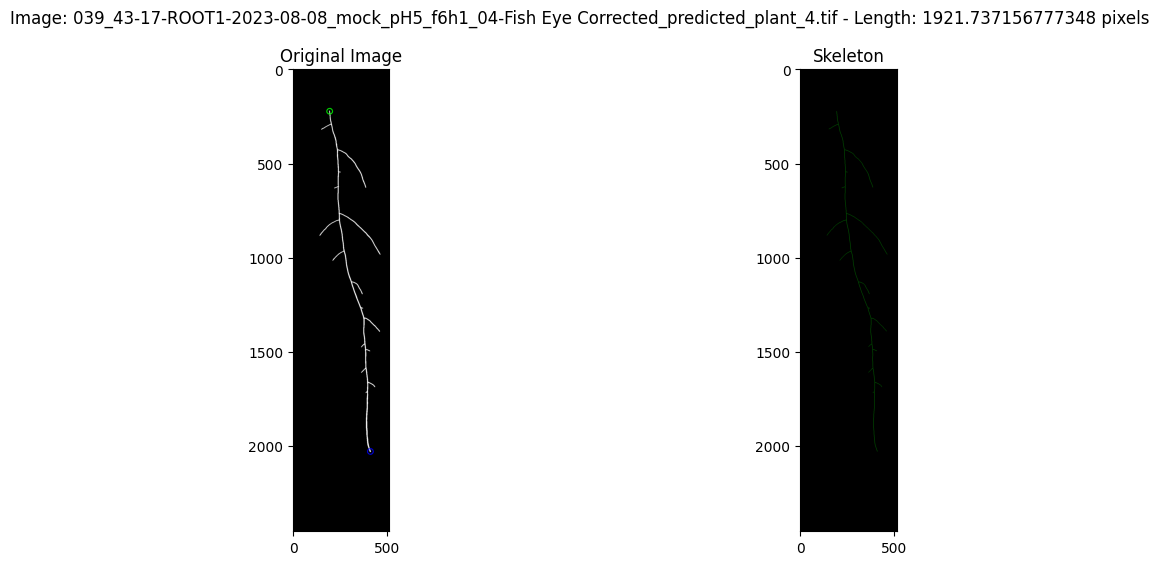

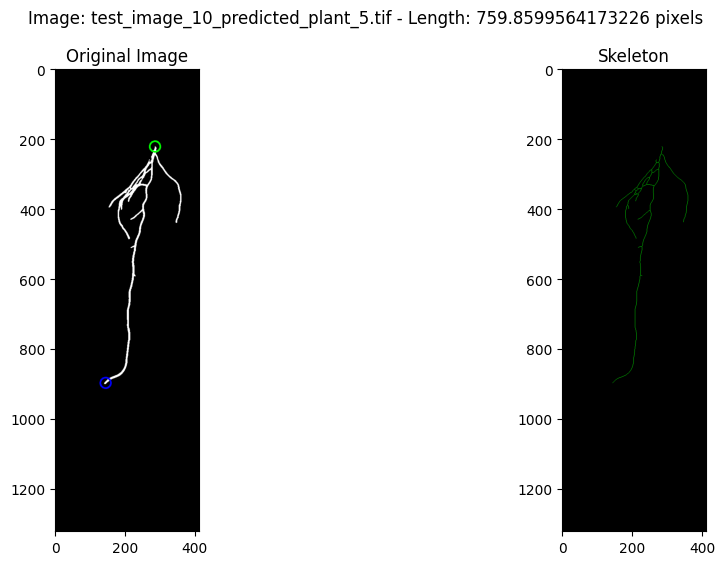

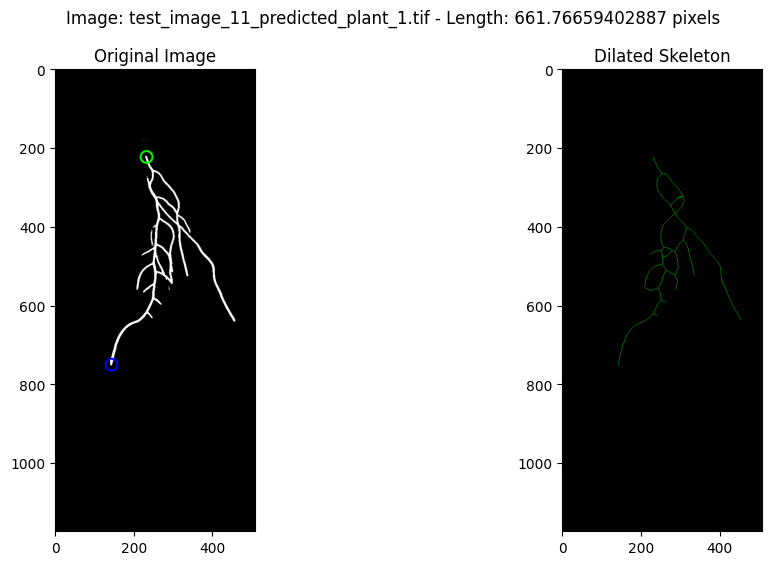

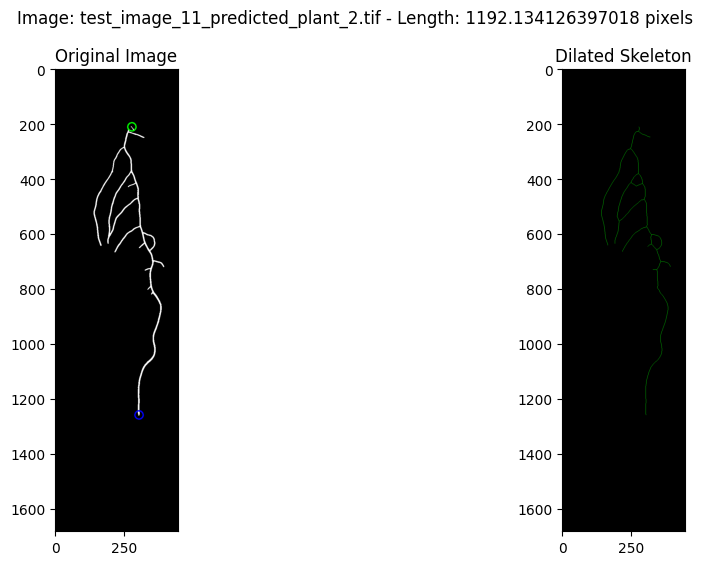

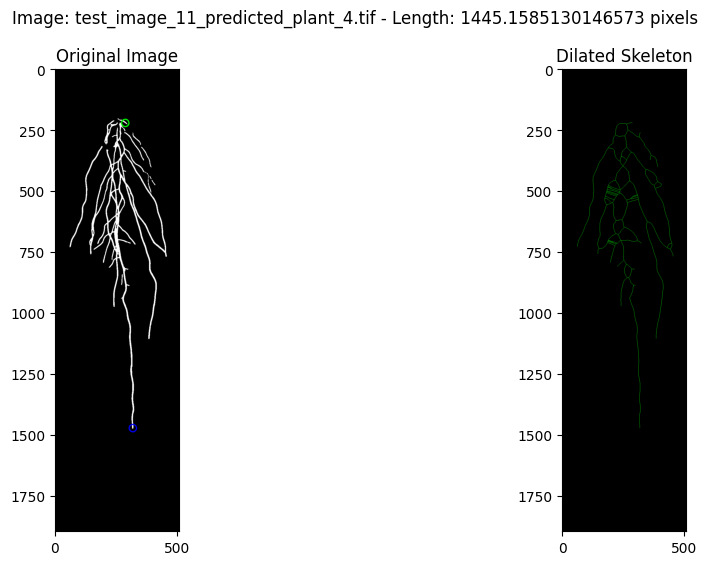

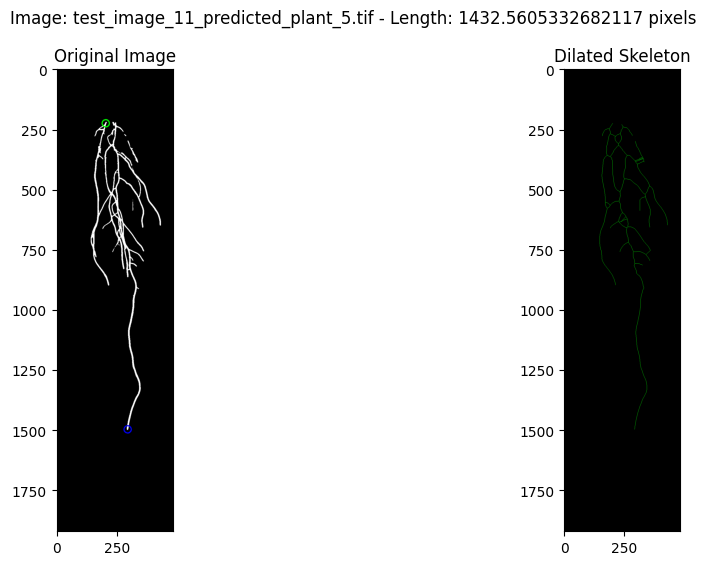

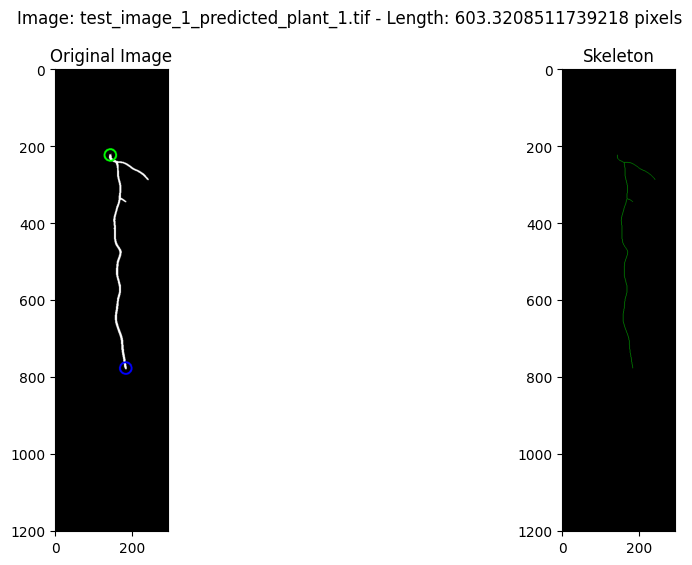

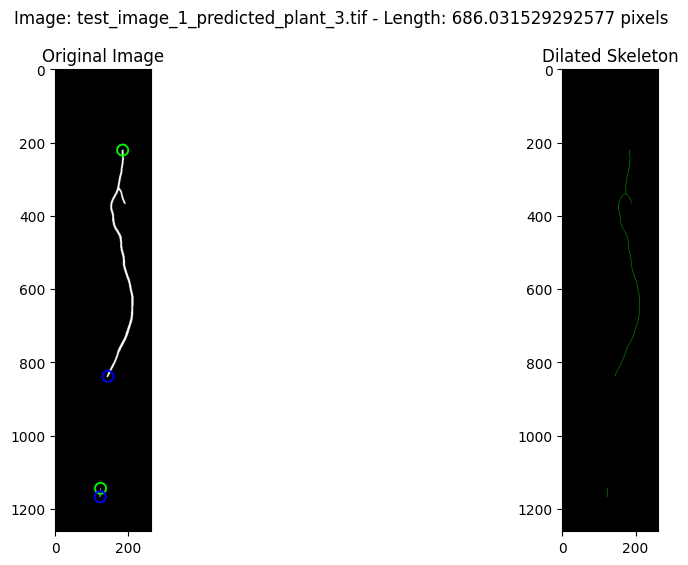

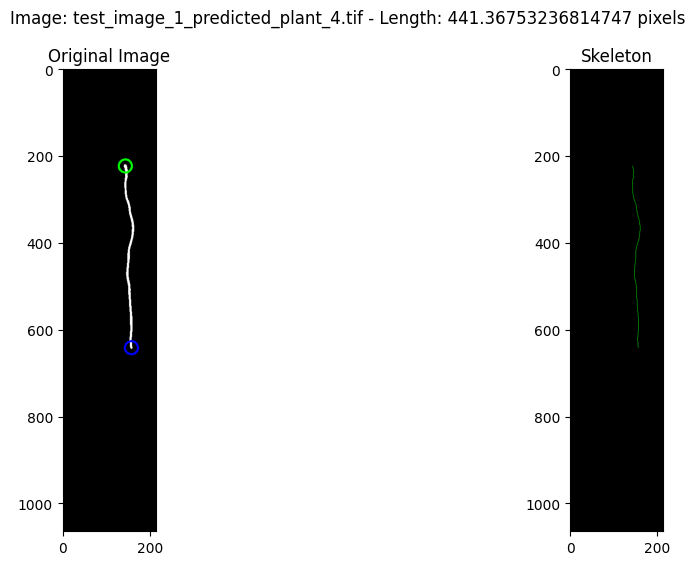

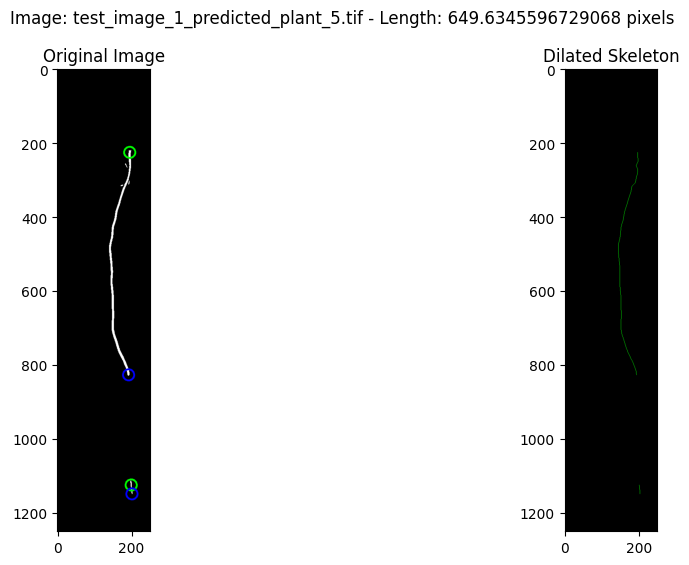

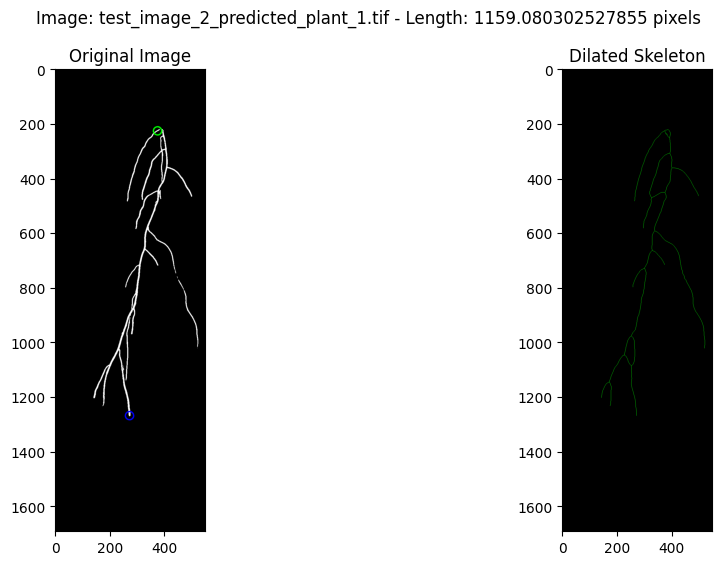

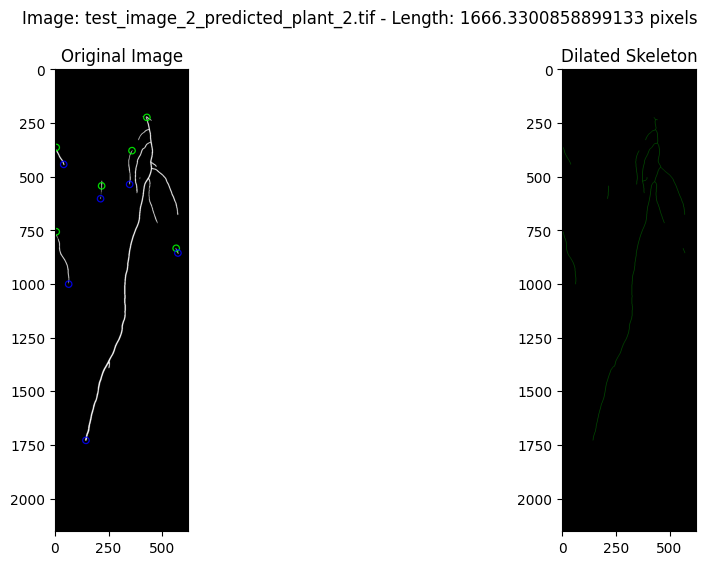

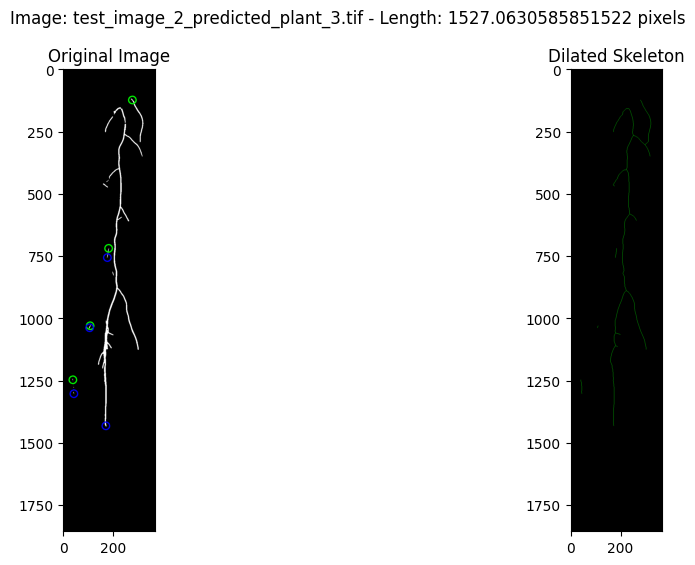

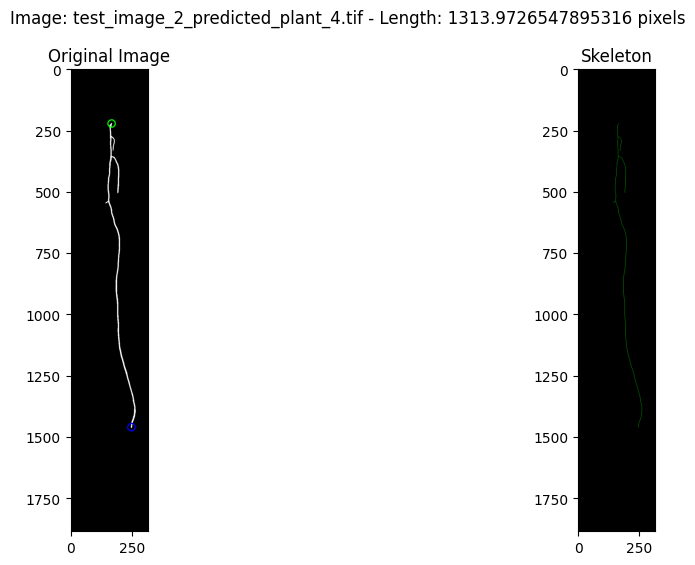

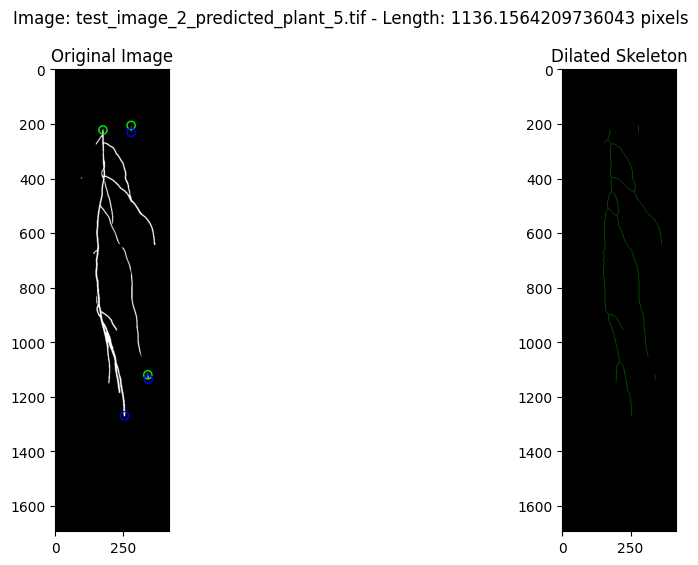

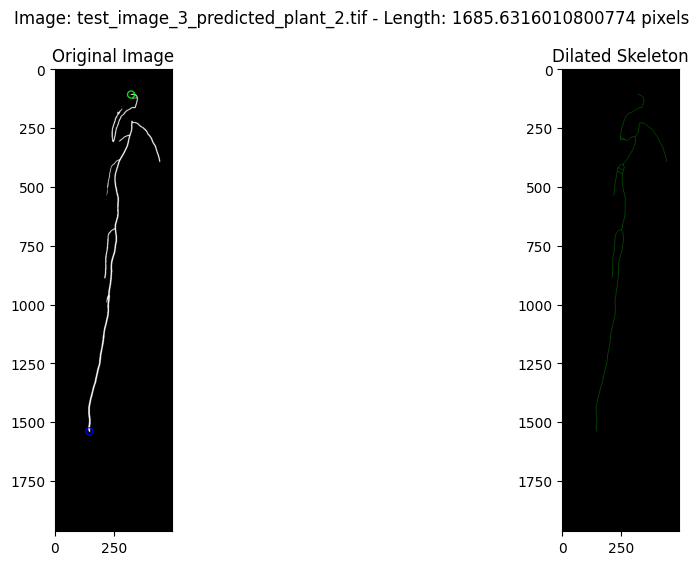

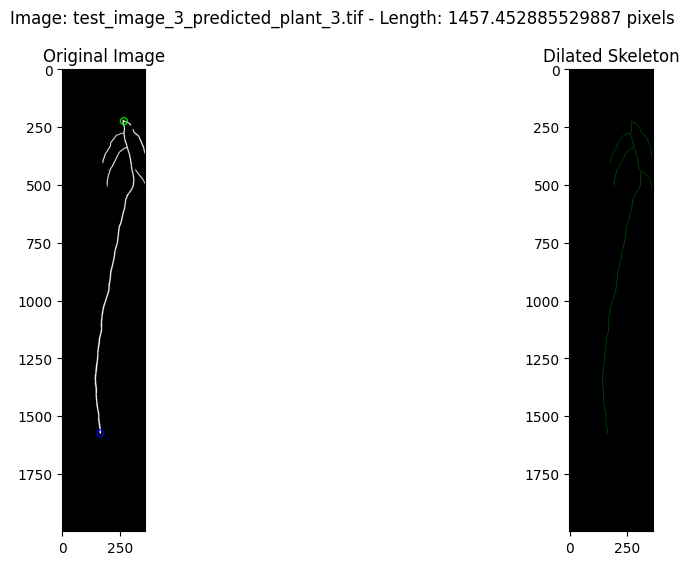

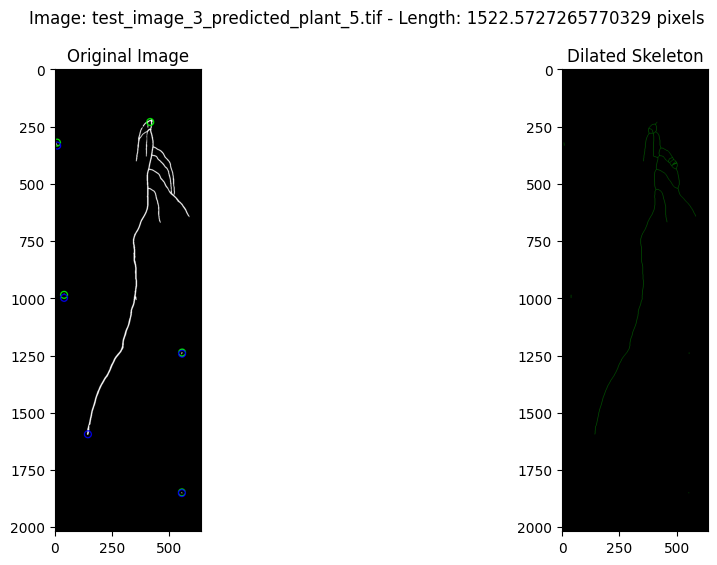

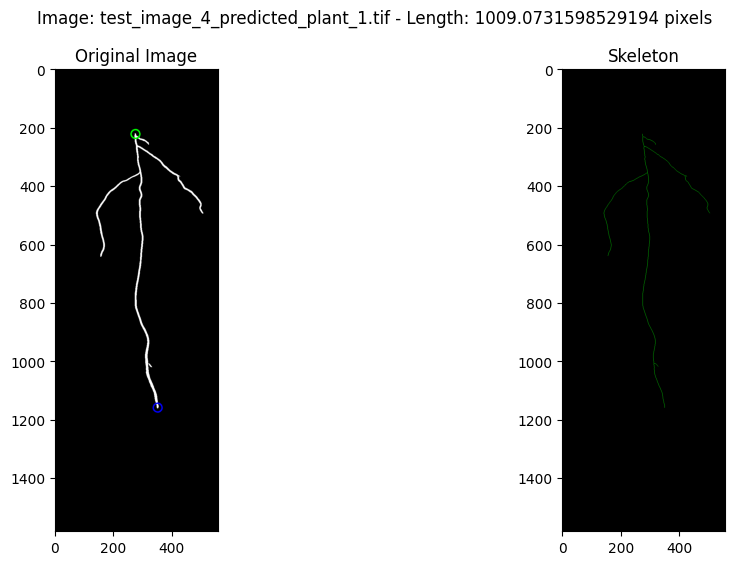

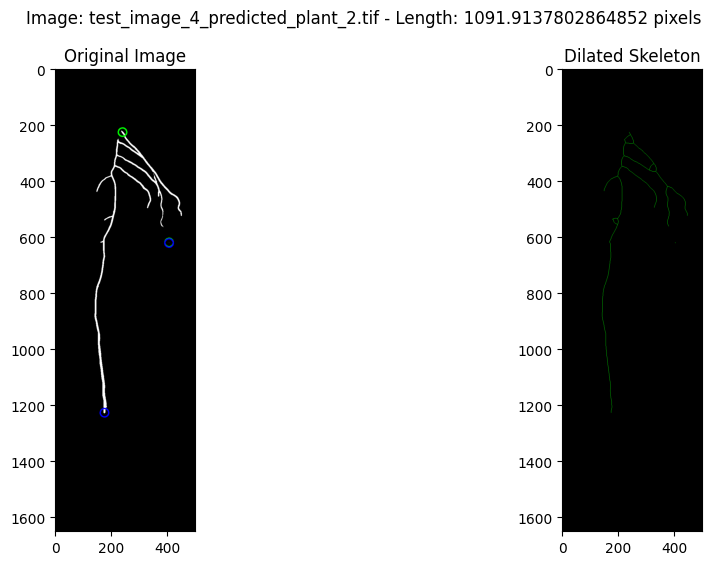

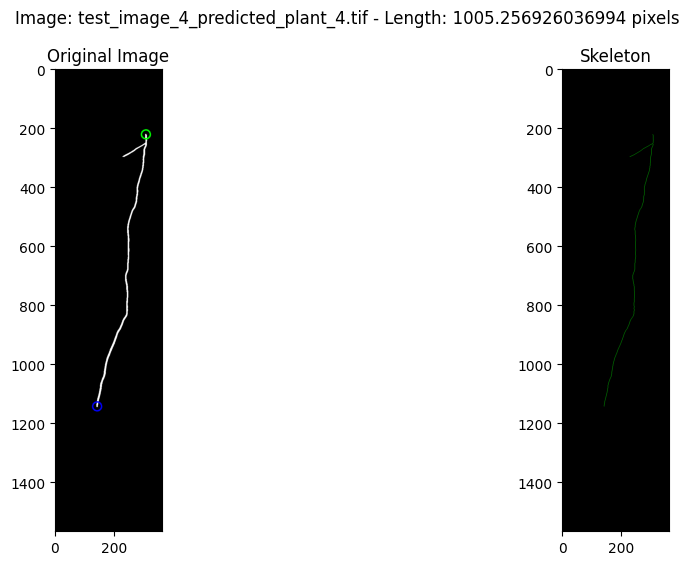

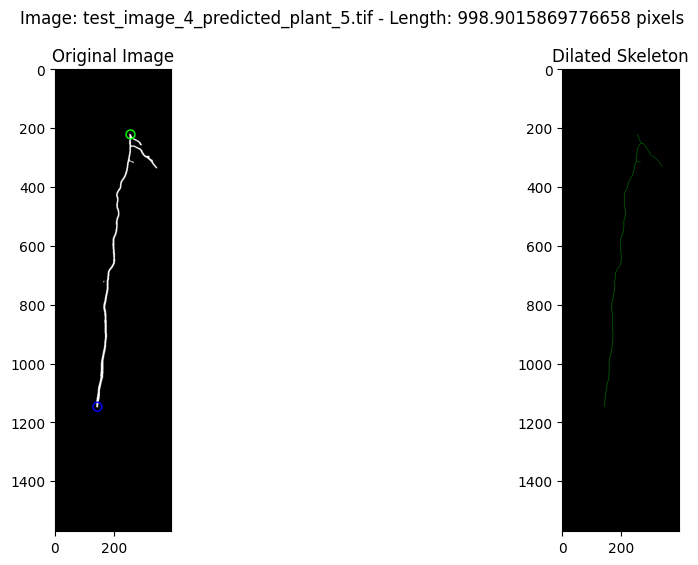

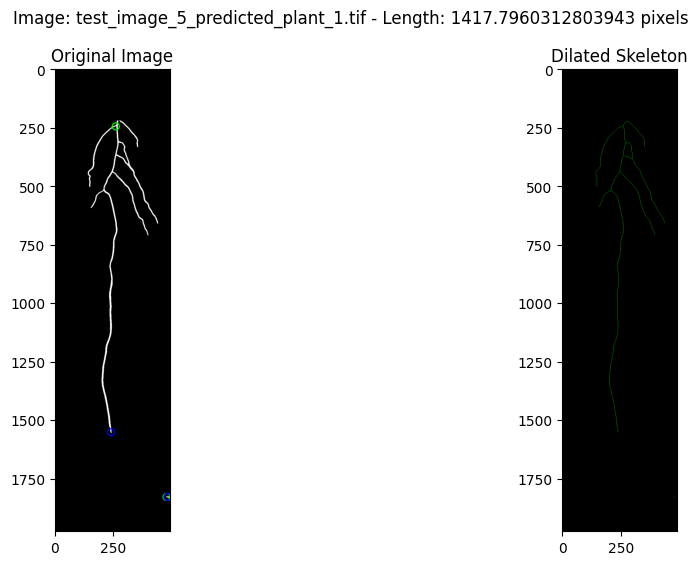

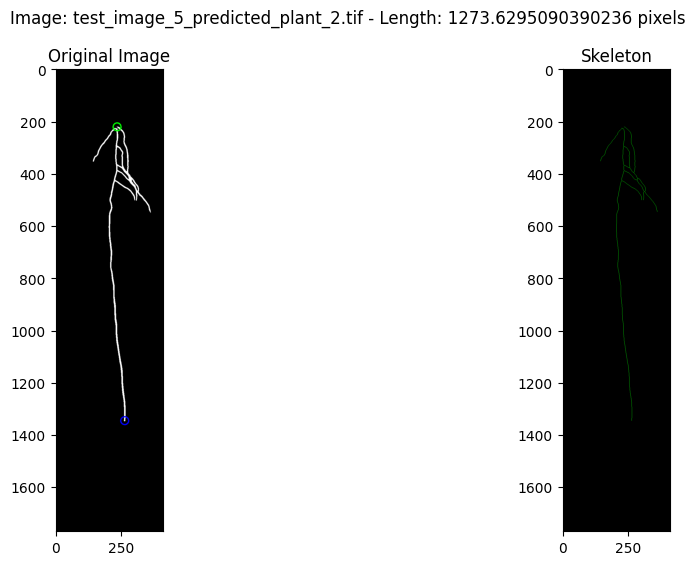

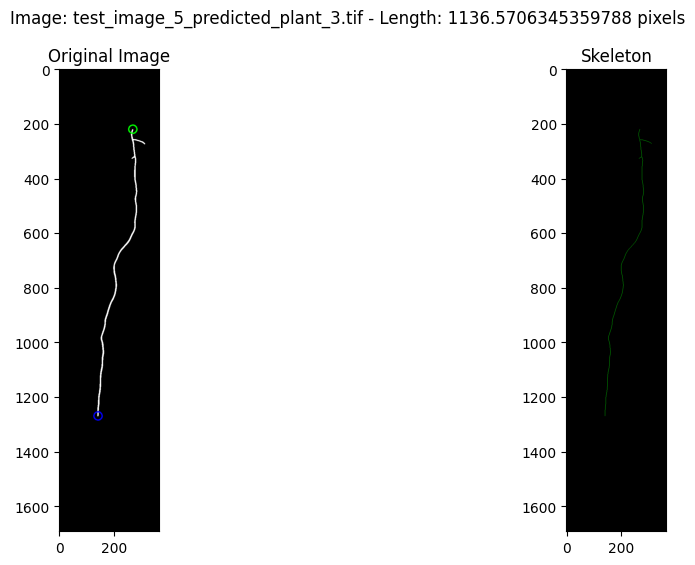

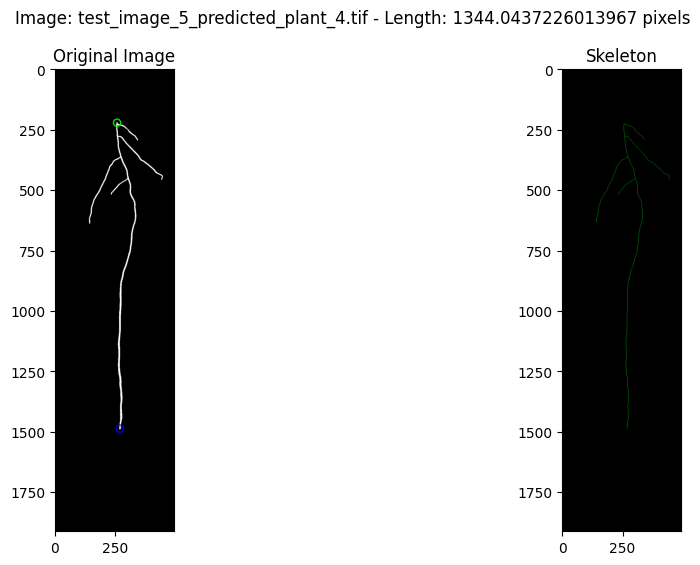

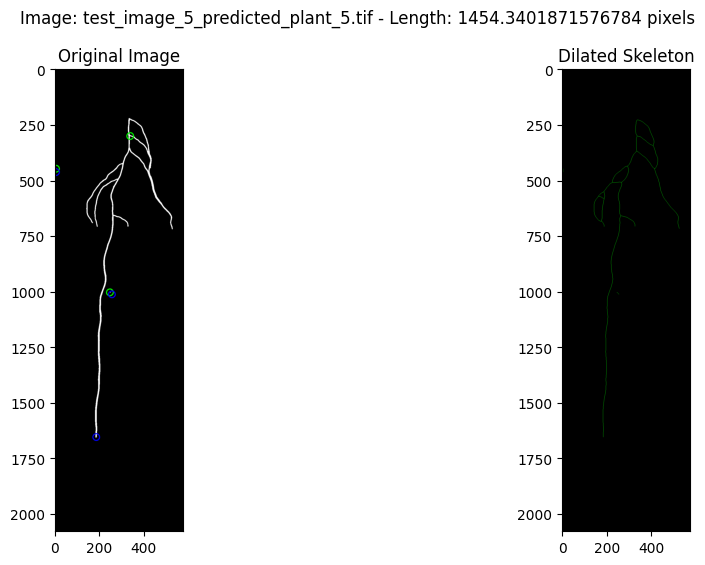

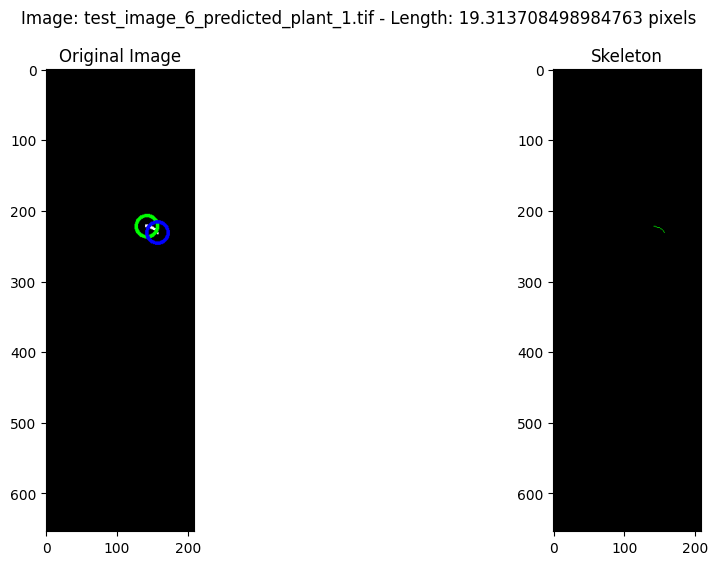

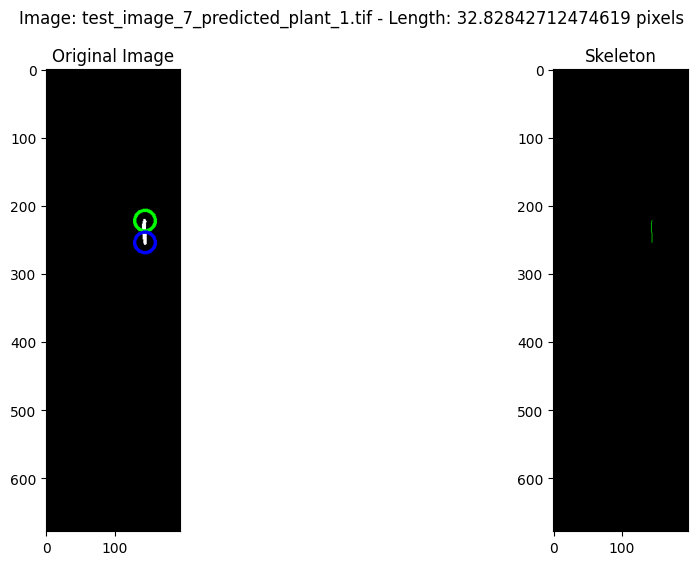

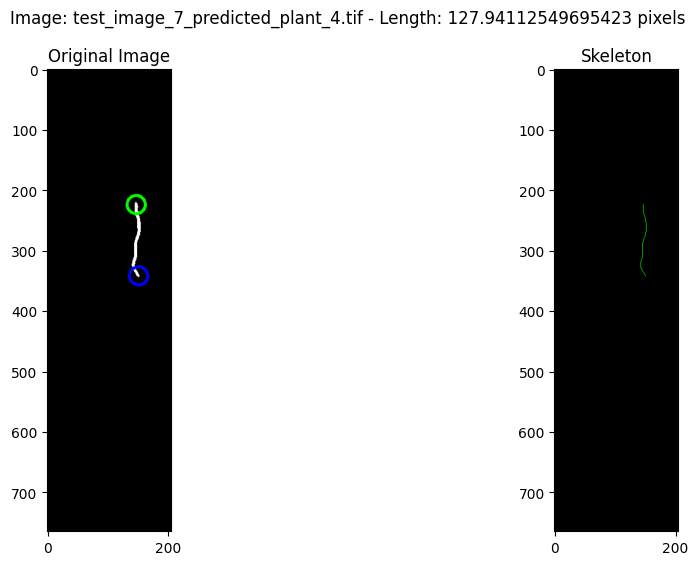

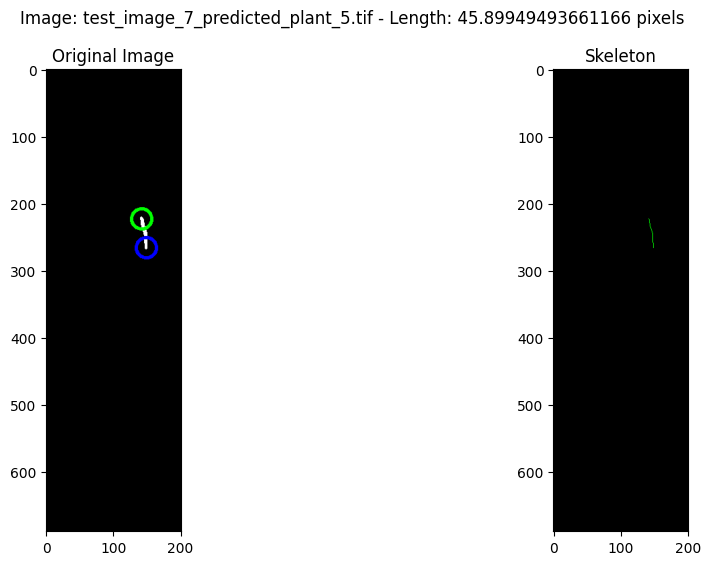

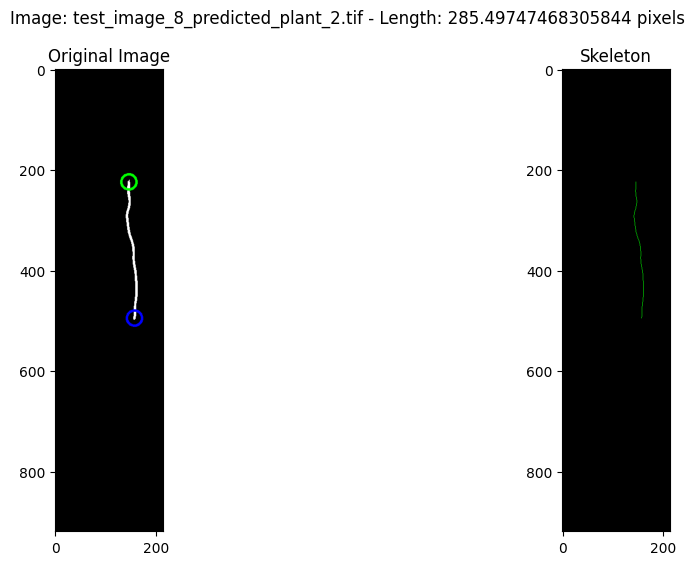

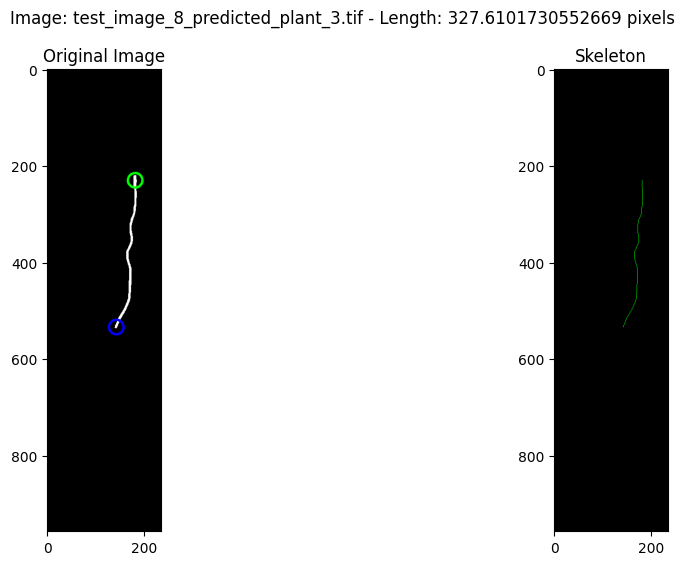

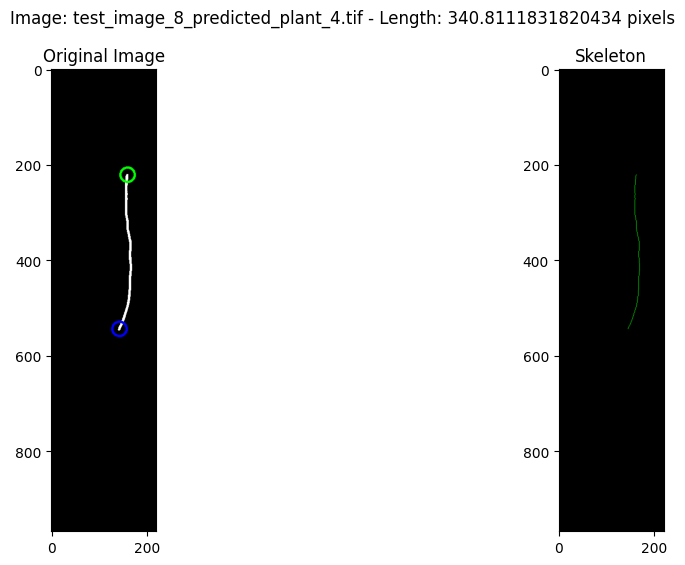

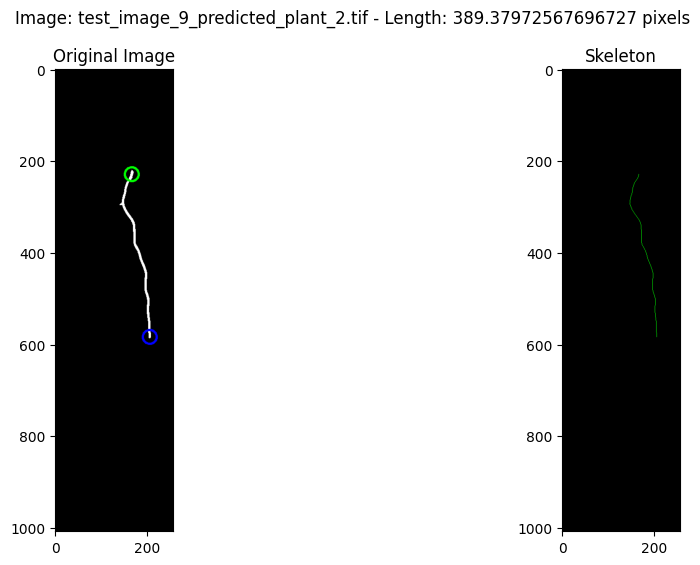

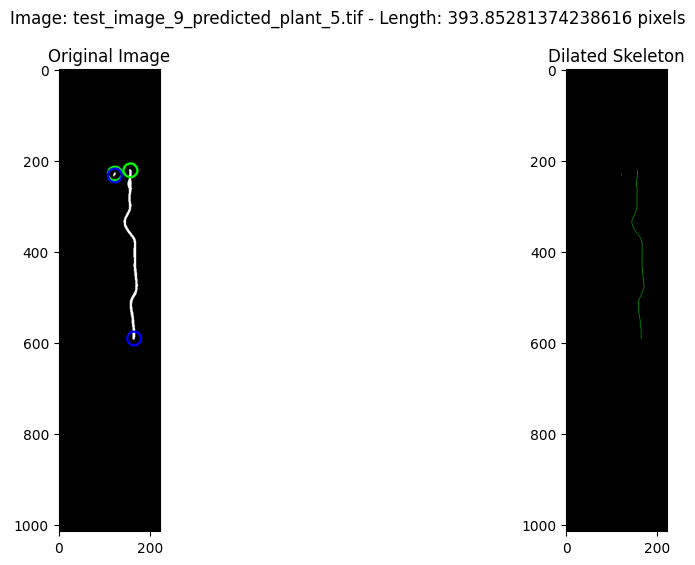

Plant ID  Length (px)
0   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   954.173665
1   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   714.965512
2   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   684.107648
3   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   685.847763
4   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   690.149278
..                                                ...          ...
85                               test_image_9_plant_1   423.764502
86                               test_image_9_plant_2   389.379726
87                               test_image_9_plant_3     0.000000
88                               test_image_9_plant_4   492.190909
89                               test_image_9_plant_5   393.852814

[90 rows x 2 columns]

In [208]:
process_images_in_folder('each_root_mask')

In [211]:
df = pd.read_csv('dataframe_measurements/results.csv')

pd.set_option('display.max_rows', None)

df

Plant ID  Length (px)
0   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   954.173665
1   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   714.965512
2   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   684.107648
3   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   685.847763
4   033_43-14-ROOT1-2023-08-08_control_pH7_-Fe+B_c...   690.149278
5   034_43-13-ROOT1-2023-08-08_pvd_OD0001_col-0_04...   523.237590
6   034_43-13-ROOT1-2023-08-08_pvd_OD0001_col-0_04...   614.409163
7   034_43-13-ROOT1-2023-08-08_pvd_OD0001_col-0_04...   435.237590
8   034_43-13-ROOT1-2023-08-08_pvd_OD0001_col-0_04...   554.923882
9   034_43-13-ROOT1-2023-08-08_pvd_OD0001_col-0_04...   358.154329
10  035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   991.109740
11  035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   719.244733
12  035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   953.161472
13  035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   908.889394
14  035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   843.788889
15  036_43-11-ROOT1-2023-08-08_pvd_OD0001_col-0_03...   450.107648
16  036_43-11-ROOT1-2023-08-08_pvd_OD0001_col-0_03...   397.852814
17  036_43-11-ROOT1-2023-08-08_pvd_OD0001_col-0_03...   420.740115
18  036_43-11-ROOT1-2023-08-08_pvd_OD0001_col-0_03...   443.923882
19  036_43-11-ROOT1-2023-08-08_pvd_OD0001_col-0_03...   453.124892
20  038_43-18-ROOT1-2023-08-08_pvd_OD01_Col0_05-Fi...   451.137085
21  038_43-18-ROOT1-2023-08-08_pvd_OD01_Col0_05-Fi...   509.421356
22  038_43-18-ROOT1-2023-08-08_pvd_OD01_Col0_05-Fi...   576.308658
23  038_43-18-ROOT1-2023-08-08_pvd_OD01_Col0_05-Fi...   588.178716
24  038_43-18-ROOT1-2023-08-08_pvd_OD01_Col0_05-Fi...   567.338095
25  039_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   957.305699
26  039_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   947.614357
27  039_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   904.931024
28  039_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...   888.872150
29  039_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_0...  1045.085353
30  039_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_04-Fi...  1625.009235
31  039_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_04-Fi...  1906.322943
32  039_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_04-Fi...  1322.445743
33  039_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_04-Fi...  1921.737157
34  039_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_04-Fi...  1568.097546
35                               test_image_1_plant_1   603.320851
36                               test_image_1_plant_2   526.710678
37                               test_image_1_plant_3   686.031529
38                               test_image_1_plant_4   441.367532
39                               test_image_1_plant_5   649.634560
40                              test_image_10_plant_1   640.646753
41                              test_image_10_plant_2   751.730014
42                              test_image_10_plant_3   782.303607
43                              test_image_10_plant_4   829.641702
44                              test_image_10_plant_5   759.859956
45                              test_image_11_plant_1   661.766594
46                              test_image_11_plant_2  1192.134126
47                              test_image_11_plant_3     0.000000
48                              test_image_11_plant_4  1445.158513
49                              test_image_11_plant_5  1432.560533
50                               test_image_2_plant_1  1159.080303
51                               test_image_2_plant_2  1666.330086
52                               test_image_2_plant_3  1527.063059
53                               test_image_2_plant_4  1313.972655
54                               test_image_2_plant_5  1136.156421
55                               test_image_3_plant_1  1412.862048
56                               test_image_3_plant_2  1685.631601
57                               test_image_3_plant_3  1457.452886
58                               test_image_3_plant_4  1499.854906
59                       